In [220]:

    
#!/usr/bin/env python
# coding: utf-8


import os
import sys
import re
import torch
from glob import glob
from openbabel import pybel
ob = pybel.ob
import numpy as np
import random
import pickle
import warnings
import requests
import os
import glob
import pandas as pd
import openbabel
import numpy as np
from operator import add
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D 
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
from biopandas.pdb import PandasPdb
from Bio.PDB.SASA import ShrakeRupley
from Bio.PDB import PDBParser
from sklearn.model_selection import train_test_split
from dask.dataframe import from_pandas
from dask.multiprocessing import get
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False, nb_workers=250,use_memory_fs=False)

df_plifSpecs=pd.DataFrame()
PYTORCH_ENABLE_MPS_FALLBACK=1
PYTORCH_ENABLE_SparseCPU_FALLBACK=1
warnings.filterwarnings("ignore")

from dask_jobqueue import SLURMCluster

train_grids=None
test_grids=None
rotations=9
full_batch=20
features_shape=628
# First training grids: 
train_label=[]
# Second testing grids: 
test_label=[]

des=dir(Descriptors)

des=[x for x in des if not x.startswith('AUTOCOR')]
des=[x for x in des if not x.startswith('BCUT2D')]
des=[x for x in des if not x.startswith('Chi')]
des=[x for x in des if not x.startswith('EState')]
des=[x for x in des if not x.startswith('Chem')]
#des=[x for x in des if not x.startswith('PEOE')]
des=[x for x in des if not x.startswith('SlogP_')]
des=[x for x in des if not x.startswith('__')]
des=[x for x in des if not x.startswith('VSA_')]
des=[x for x in des if not x.startswith('descList')]
des=[x for x in des if not x.startswith('autocorr')]
des=[x for x in des if not x.startswith('abc')]
des=[x for x in des if not x.startswith('_')]
des=[x for x in des if not x.startswith('SMR')]
des=[x for x in des if not x.startswith('PropertyFunctor')]
des=[x for x in des if not x.startswith('names')]
des=[x for x in des if not x.startswith('setupAUTOCorrDescriptors')]
des=[x for x in des if not x.startswith('rdPartialCharges')]
des=[x for x in des if not x.startswith('rdMolDescriptors')]
#des=[x for x in des if not x.startswith('BalabanJ')]
#des=[x for x in des if not x.startswith('BertzCT')]

des=["Descriptors."+ item for item in des]

FragID={}
    
# cluster = SLURMCluster(cores=1024,
#                        processes=12,
#                        memory="250GB",
#                       # account="hmslati",
#                       # walltime="01:00:00",
#                        queue="gpu-bigmem")

# PLEASE READ -> 45次实验分别进行10倍交叉验证，取平均

#Converts the protein-ligand complexes into 4D tensor. 
class Feature_extractor():
    def __init__(self):
        
        self.res_types=['MET','THR','VAL','PRO','ASP',
                        'ARG','SER','GLU','ILE','ALA',
                        'GLY','LYS','TRP','TYR','LEU',
                       'ASN','PHE','CYS','HIS','GLN']
        self.aa_atoms=[' N  ', ' HN1', ' HN2', ' HN3', ' CA ', ' HA ', ' C  ', ' O  ', 
                       ' CB ', ' HB1', ' HB2', ' CG ', ' HG1', ' HG2', ' SD ', ' CE ', ' HE1', 
                       ' HE2', ' HE3', ' H  ', ' HB ', ' OG1', ' CG2', '1HG2', '2HG2', '3HG2', 
                       ' CG1', '1HG1', '2HG1', '3HG1', ' CD ', ' HD1', ' HD2', ' OD1', ' OD2', 
                       ' NE ', ' HE ', ' CZ ', ' NH1', '1HH1', '2HH1', ' NH2', '1HH2', '2HH2', 
                       ' OG ', ' HG ', ' OE1', ' OE2', ' CD1', '1HD1', '2HD1', '3HD1', ' HB3', 
                       ' HA1', ' HA2', ' NZ ', ' HZ1', ' HZ2', ' HZ3', ' CD2', ' NE1', ' CE2', 
                       ' CE3', ' CZ2', ' CZ3', ' CH2', ' HH2', ' CE1', ' OH ', ' HH ', '1HD2', 
                       '2HD2', '3HD2', ' ND2', ' HZ ', ' SG ', ' ND1', ' NE2', '1HE2', '2HE2', ' OXT']
        self.atom_codes = {}

        # 89 to 96 will be reserved to PLIF features as follows:
        # 89: hydrophobic
        # 90: hbond
        # 91: waterbridge
        # 92: saltbridge
        # 93: pistacking
        # 94: pication
        # 95: halogen
        # 96: metal
        # 97-116: amino acid memberships
        # 117-197: amino acid atom types
        # 198-364: fragment mebership
        
        # rarely occuring elements: ['4', '13', '22-23', '25', '28', '32', '40', '45', '47-52', '55', '75-76', '78', '80', '82'] 
        others = ([4,13,25,28,32,40,45,55,78,80,82]+list(range(22,24))+list(range(47,53))+list(range(75,77)))
        plif_specs=list(range(89,97))
        aa_specs=list(range(97,117))
        self.aa_specs_dic = dict(map(lambda i,j : (i,j) , self.res_types,aa_specs))
        aa_atom_types=list(range(117,198))
        self.aa_atoms_dic = dict(map(lambda i,j : (i,j) , self.aa_atoms,aa_atom_types))
        self.frag_mem=list(range(198,365))
        #C and N atoms can be hybridized in three ways and S atom can be hybridized in two ways here. 
        #Hydrogen atom is also considered for feature extraction. I think phosphor atom has 3 or 5 as hyb states but 
        # in biological system its usually the same recurrent phosphate even in most small molecules so safe to assume one
        # hybridization state for this purpose. 
        atom_types = [1,(6,1),(6,2),(6,3),(7,1),(7,2),(7,3),8,15,(16,2),(16,3),
                      34,9,17,35,53,11,12,13,14,5,19,20,25,29,28,30,33,3,27,24,26,31,42,79,44,74,others]+plif_specs+ \
                                                                            aa_specs+aa_atom_types+self.frag_mem
      
        for i, j in enumerate(atom_types):
            if type(j) is list:
                for k in j:
                    self.atom_codes[k] = i
                
            else:
                self.atom_codes[j] = i              
        
        self.sum_atom_types = len(atom_types)
        
    #Onehot encoding of each atom. The atoms in protein or ligand are treated separately.
    def encode(self, atomic_num, orig_coords, plifs, molprotein, res=None, aa_atom=None, frag=None):
        encoding = np.zeros(self.sum_atom_types*2)
        if molprotein == 1:
            encoding[self.atom_codes[atomic_num]] = 1.0
            encoding[self.atom_codes[res]] = 1.0
            encoding[self.atom_codes[aa_atom]] = 1.0
            for coord, plif_feats in plifs.items():
                if [round(item) for item in coord] == [round(item) for item in orig_coords]:
                    encoding[self.atom_codes[89]] = 1.0 if plifs[coord][0] == 'hydrophobic' \
                    else 0.0
                    encoding[self.atom_codes[90]] = 1.0 if plifs[coord][0] == 'hbond' \
                    else 0.0
                    encoding[self.atom_codes[91]] = 1.0 if plifs[coord][0] == 'waterbridge' \
                    else 0.0
                    encoding[self.atom_codes[92]] = 1.0 if plifs[coord][0] == 'saltbridge' \
                    else 0.0
                    encoding[self.atom_codes[93]] = 1.0 if plifs[coord][0] == 'pistacking' \
                    else 0.0
                    encoding[self.atom_codes[94]] = 1.0 if plifs[coord][0] == 'pication' \
                    else 0.0
                    encoding[self.atom_codes[95]] = 1.0 if plifs[coord][0] == 'halogen' \
                    else 0.0
                    encoding[self.atom_codes[96]] = 1.0 if plifs[coord][0] == 'metal' \
                    else 0.0               
#                     #distance
#                     encoding[self.atom_codes[97]] = plifs[coord][1]
        else:
            encoding[self.sum_atom_types+self.atom_codes[atomic_num]] = 1.0
            for coord, plif_feats in plifs.items():
                if [round(item) for item in coord] == [round(item) for item in orig_coords]:
                    encoding[self.sum_atom_types+self.atom_codes[89]] = 1.0 if plifs[coord][0] == 'hydrophobic' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[90]] = 1.0 if plifs[coord][0] == 'hbond' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[91]] = 1.0 if plifs[coord][0] == 'waterbridge' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[92]] = 1.0 if plifs[coord][0] == 'saltbridge' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[93]] = 1.0 if plifs[coord][0] == 'pistacking' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[94]] = 1.0 if plifs[coord][0] == 'pication' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[95]] = 1.0 if plifs[coord][0] == 'halogen' \
                    else 0.0
                    encoding[self.sum_atom_types+self.atom_codes[96]] = 1.0 if plifs[coord][0] == 'metal' \
                    else 0.0
#                     #distance
#                     encoding[self.sum_atom_types+self.atom_codes[97]] = plifs[coord][1]
            for ndx, coord_list in enumerate([*frag]):
                if any(key == tuple(round(item) for item in orig_coords) for key in [tuple(round(y) for y in x) 
                                                                                     for x in coord_list]):
                    encoding[self.sum_atom_types+self.atom_codes[self.frag_mem[0]]-1:-1]=(frag[coord_list][ndx])
                    
        return encoding
    

    #Get atom coords and atom features from the complexes.   
    def get_features(self, molecule, plifs, molprotein, frags=None):
        coords = []
        features = []
        obmol = molecule.OBMol    
        for res in ob.OBResidueIter(obmol):
            for atom in ob.OBResidueAtomIter(res):
                coords.append([atom.GetX(),atom.GetY(),atom.GetZ()])
                if atom.GetAtomicNum() in [6,7,16]:
                    atomicnum = (atom.GetAtomicNum(),atom.GetHyb())
                    features.append(self.encode(atomicnum,(atom.GetX(),atom.GetY(),atom.GetZ()),plifs,molprotein,
                                               self.aa_specs_dic[res.GetName()] if not res.IsHetAtom(atom)
                                                                else None, self.aa_atoms_dic[res.GetAtomID(atom)]
                                                if not res.IsHetAtom(atom) else None,
                                               frags))
                else:
                    features.append(self.encode(atom.GetAtomicNum(),(atom.GetX(),atom.GetY(),atom.GetZ()),
                                                plifs,molprotein,self.aa_specs_dic[res.GetName()] 
                                                if not res.IsHetAtom(atom) else None, 
                                                self.aa_atoms_dic[res.GetAtomID(atom)]
                                                if not res.IsHetAtom(atom) else None,frags))
        
        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)

        return coords, features
     
    #Define the rotation matrixs of 3D stuctures.
    def rotation_matrix(self, t, roller):
        if roller==0:
            return np.array([[1,0,0],[0,np.cos(t),np.sin(t)],[0,-np.sin(t),np.cos(t)]])
        elif roller==1:
            return np.array([[np.cos(t),0,-np.sin(t)],[0,1,0],[np.sin(t),0,np.cos(t)]])
        elif roller==2:
            return np.array([[np.cos(t),np.sin(t),0],[-np.sin(t),np.cos(t),0],[0,0,1]])

    #Generate 3d grid or 4d tensor. Each grid represents a voxel. Each voxel represents the atom in it by onehot encoding of atomic type.
    #Each complex in train set is rotated 9 times for data amplification.
    #The complexes in core set are not rotated. 
    #The default resolution is 20*20*20.
    def grid(self,coords, features, resolution=1.0, max_dist=10.0, rotations=19):
        assert coords.shape[1] == 3
        assert coords.shape[0] == features.shape[0]  

        grid=torch.zeros((rotations+1,20,20,20,features_shape))

        x=y=z=np.array(range(-10,10),dtype=np.float32)+0.5
        for i in range(len(coords)):
            coord=coords[i]
            tmpx=abs(coord[0]-x)
            tmpy=abs(coord[1]-y)
            tmpz=abs(coord[2]-z)
            if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                grid[0,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]
        
        for j in range(rotations):
            theta = random.uniform(np.pi/18,np.pi/2)
            roller = random.randrange(3)
            coords = np.dot(coords, self.rotation_matrix(theta,roller))
            for i in range(len(coords)):
                coord=coords[i]
                tmpx=abs(coord[0]-x)
                tmpy=abs(coord[1]-y)
                tmpz=abs(coord[2]-z)
                if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                    grid[j+1,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]
                
        return grid
    
class PLIF:
    def __init__(self, PDB: str, MOL_SPLIT_START: int = 70, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(PLIF,self).__init__()
        
        self.MOL_SPLIT_START=MOL_SPLIT_START
        self.pdb=PDB
        self.records=['ATOM']
        self.values=['HOH','CL','MG','ZN','MN','CA']
        self.ions=['CL','MG','ZN','MN','CA']
        self.interaction_slices={"hydrophobic":[0,1,6,7,8,9,10],
            "hbond":[0,1,7,11,13,15,16],
            "waterbridge":[0,1,[6,7],11,13,16,17],
            "saltbridge":[0,1,7,10,3,11,12],
            "pistacking":[0,1,7,11,6,12,13],
            "pication":[0,1,7,11,3,12,13],
            "halogen":[0,1,7,10,12,14,15],
            "metal":[0,1,11,8,6,17,16]} 

        self.column_names = ['RESNR', 'RESTYPE', 'DIST', 'LIG_IDX','PROT_IDX','LIG_COORDS', 'PROT_COORDS']
        self.path = os.getcwd()


    def okToBreak(self, bond):
        """
        Here we apply a bunch of rules to judge if the bond is OK to break.

        Parameters
        ----------
        bond :
            RDkit MOL object

        Returns
        -------
        Boolean :
            OK or not to break.
        """
        # See if the bond is in Ring (don't break that)
        if bond.IsInRing():
            return False
        # We OK only single bonds to break
        if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
            return False

        # Get the beginning atom of the bond
        begin_atom = bond.GetBeginAtom()
        # Get the ending atom of the bond
        end_atom = bond.GetEndAtom()
        # What kind of neighbors does these end and begenning atoms have? We need a family of no less than 5!
        neighbor_end=list(end_atom.GetNeighbors())
        neighbor_begin=list(begin_atom.GetNeighbors())
        if (len(neighbor_end) + len(neighbor_begin)) <5:
            return False
        #for atm in neighbor_end:
            #print(atm.GetAtomicNum())
        #print(begin_atom.GetAtomicNum(), end_atom.GetAtomicNum(), MOL_SPLIT_START)
        
        # Now check if end or begenning atoms are in ring (we dont wanna bother those)
        if not(begin_atom.IsInRing() or end_atom.IsInRing()):
            return False
        elif begin_atom.GetAtomicNum() >= self.MOL_SPLIT_START or \
                end_atom.GetAtomicNum() >= self.MOL_SPLIT_START:
            return False
        elif end_atom.GetAtomicNum() == 1:
            return False
        else:
            return True

    def undo_id_label (self, frag, split_id):
        # I am trying to restore Hydrogens where the break happened
        for i, atom in enumerate(frag.GetAtoms()):
            if atom.GetAtomicNum() >= split_id:
                atom.SetAtomicNum(1)

        return frag

    def _3Descriptors(self, mol):
        collected_descriptors=[]
        collected_descriptors.append(Descriptors3D.Asphericity(mol))
        collected_descriptors.append(Descriptors3D.Eccentricity(mol))
        collected_descriptors.append(Descriptors3D.InertialShapeFactor(mol))
        collected_descriptors.append(Descriptors3D.NPR1(mol))
        collected_descriptors.append(Descriptors3D.NPR2(mol))
        collected_descriptors.append(Descriptors3D.PMI1(mol))
        collected_descriptors.append(Descriptors3D.PMI2(mol))
        collected_descriptors.append(Descriptors3D.PMI3(mol))
        collected_descriptors.append(Descriptors3D.RadiusOfGyration(mol))
        collected_descriptors.append(Descriptors3D.SpherocityIndex(mol))
    
        return collected_descriptors

    def FragID_assign(self, mol):
        invariantID=AllChem.GetHashedMorganFingerprint(mol,radius=2,nBits=1024)
        key=str(''.join([str(item) for item in invariantID]))
        try:
            return FragID[key]
        except:
            FragID[key] = len(FragID)+1
            return [FragID[key]]
        
    def FragID_assign_2(self, mol):
            return list(MACCSkeys.GenMACCSKeys(mol))

    def atoms_coords_frags(self, mol):
        coords=[]
        for idx, atom in enumerate(mol.GetAtoms()):
            positions = mol.GetConformer().GetAtomPosition(idx)
            coords.append((positions.x, positions.y, positions.z))
        return coords


    # Divide a molecule into fragments
    def split_interact_molecule(self, mol, pdb):
        
        ## here we calculate 2d descriptors

        descriptors2D=[eval(des[idx])(mol) for idx,i in enumerate(des)]
        
        # we may need to overwrite with rdkit sanitized mol
        w = Chem.PDBWriter(f"tmp_HETATM_{pdb}.pdb")
        w.write(mol)
        w.close()
        
        with open(f"tmp_HETATM_{pdb}.pdb") as f1, open(f"HETATM_{pdb}.pdb", 'w') as f2:
            for line in f1:
                if ('HETATM' in line) and not any(ion in line for ion in self.ions):
                    f2.write(line)
            f2.close()
        
        split_id = self.MOL_SPLIT_START

        res = []
        res_no_id=[]

        to_check = [mol]
        while len(to_check) > 0:
            ms = self.spf(to_check.pop(), split_id)
            if len(ms) == 1:
                res += ms
            else:
                to_check += ms
                split_id += 1
        for frag in res:
            res_no_id.append(self.undo_id_label(frag, self.MOL_SPLIT_START))
        
        #stop everything if frags exceed 10
        if len(res_no_id) > 10:
            raise Exception(f"sorry does not support large ligands with more than 10 fragments possible")
        
        # here we get the coords for each fragment (this is purely to match later and map to descriptors and memberships):
        frag_coords=list(map(self.atoms_coords_frags, res_no_id))
        
        ## here we calculate 3d descriptors
        descriptors3D=list(map(self._3Descriptors, res_no_id))
        
        ## here we get fragment membership
        memberships=list(map(self.FragID_assign_2,res_no_id))

        #descriptors3D=list(map(add, descriptors3D, memberships)) 
                         
        # Now we index each of the 3D feats into a slot of the allocated 10 fragments (max). If exceed return error.
        # i.e. we discard that sample
        trail=[0,0,0,0,0,0,0,0,0,0,0]
        trail=[trail]*10
        for idx, pos in enumerate(zip(trail,descriptors3D)):
            trail[idx]=descriptors3D[idx]    
            
        descriptors3D=trail
        
        data = data2 = ""

        # Reading data from file1
        with open(f"ATOM_{pdb}.pdb") as fp:
            data = fp.read()

        # Reading data from file2

        with open(f"HETATM_{pdb}.pdb") as fp:
            data2 = fp.read()
        data += data2

        with open(f"HOH_{pdb}.pdb") as fp:
            data3 = fp.read()
        data += data3

        with open (f"ATOM_{pdb}_clean.pdb", 'w') as fp:
            fp.write(data)
        
        
        return self.interaction_df(f"ATOM_{pdb}_clean.pdb", descriptors2D, descriptors3D, frag_coords, memberships)


    # Function for doing all the nitty gritty splitting work.
    # loops over bonds until bonds get exhausted or bonds are ok to break, whichever comes first. If ok to break, then each
    # fragment needs to be checked individually again through the loop
    def spf(self, mol, split_id):

        bonds = mol.GetBonds()
        for i in range(len(bonds)):
            if self.okToBreak(bonds[i]):
                mol = Chem.FragmentOnBonds(mol, [i])
                # Dummy atoms are always added last
                n_at = mol.GetNumAtoms()
                print('Split ID', split_id)
                mol.GetAtomWithIdx(n_at-1).SetAtomicNum(split_id)
                mol.GetAtomWithIdx(n_at-2).SetAtomicNum(split_id)
                return Chem.rdmolops.GetMolFrags(mol, asMols=True)

        # If the molecule could not been split, return original molecule
        return [mol]
    #get_fragments(fragment_mols)

    def retreive_plip_interactions(self, pdb_file):
        """
        Retreives the interactions from PLIP.

        Parameters
        ----------
        pdb_file :
            The PDB file of the complex. 

        Returns
        -------
        dict :
            A dictionary of the binding sites and the interactions.
        """
        protlig = PDBComplex()   #instantiate the loader from PLIP
        protlig.load_pdb(pdb_file)   # load the pdb file
        for ligand in protlig.ligands:
            protlig.characterize_complex(ligand)   # find ligands and analyze interactions
        sites = {}
        # loop over binding sites
        for key, site in sorted(protlig.interaction_sets.items()):
            binding_site = BindingSiteReport(site)   # collect data about interactions
            # tuples of *_features and *_info will be converted to pandas DataFrame
            keys = (
                "hydrophobic",
                "hbond",
                "waterbridge",
                "saltbridge",
                "pistacking",
                "pication",
                "halogen",
                "metal"
            )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with 
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RES_number', 'RES_type', ..., 'LIG_coord', 'PROT_coord')
        # 2. information for each of these features, e.g. for hydrophobic
        # ('RES_number', 'RES_type', ..., 'LIG_coord', 'PROT_coord')

            interactions = {
                k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
                for k in keys
            }
            sites[key] = interactions
        return sites

    def get_coords_prot(self, RESNR):
        ppdb = PandasPdb()
        ppdb.read_pdb(f"{self.pdb.split('.')[0]}_protein.pdb")
        only_protein=ppdb.df['ATOM']
        resnr_coords=[]
        for i in RESNR:
            resnr_coords.append(list(only_protein[only_protein['atom_number']==int(i)][['x_coord', 'y_coord', 'z_coord']].values[0]))
        return resnr_coords
    
    def interaction_df(self, pdb_file, descriptors2D, descriptors3D, frag_coords, memberships):

        all_interactions_df = pd.DataFrame()


        # We create the dictionary for the complex of interest:

        file_id=pdb_file.split('.')[0]
        raw=file_id.split('_')[1]

        interactions_by_site = self.retreive_plip_interactions(pdb_file)

        # Let’s see how many binding sites are detected:
#         print(
#             f"Number of binding sites detected in {pdb_id} : "
#             f"{len(interactions_by_site)}\n"
#             f"with {interactions_by_site.keys()}"
#         )
        # In this case, the first binding site containing ligand 03P will be further investigated.
        index_of_selected_site = 0
        selected_site = list(interactions_by_site.keys())[index_of_selected_site]
        #print(selected_site)


        valid_types = [
                "hydrophobic",
                "hbond",
                "waterbridge",
                "saltbridge",
                "pistacking",
                "pication",
                "halogen",
                "metal",
            ]

        for _type in valid_types:
            output_df=self.create_df_from_binding_site(raw, descriptors2D, descriptors3D, frag_coords, memberships,
                                                       interactions_by_site[selected_site],
                                                       selected_site,
                                                  interactions_by_site,
                                                  interaction_type=_type)
            all_interactions_df=all_interactions_df.append(output_df)
        all_interactions_df = all_interactions_df[all_interactions_df['RESNR'].notna()]
        all_interactions_df.to_csv(f"{self.path}/results_plifs/{raw}_plifs_and_properties.csv", index=False)
        return all_interactions_df


    # We can construct a pandas.DataFrame for a binding site and particular interaction type.

    def create_df_from_binding_site(self, raw, descriptors2D, descriptors3D, frag_coords, memberships,
                                    selected_site_interactions, selected_site,
                                    interactions_by_site, interaction_type="hbond"):
        """
        Creates a data frame from a binding site and interaction type.

        Parameters
        ----------
        selected_site_interactions : dict
            Precalculated interactions from PLIP for the selected site
        interaction_type : str
            The interaction type of interest (default set to hydrogen bonding).

        Returns
        -------
        pd.DataFrame :
            DataFrame with information retreived from PLIP.
        """
        # check if interaction type is valid:
        valid_types = [
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        ]


        if interaction_type not in valid_types:
            print("!!! Wrong interaction type specified. Hbond is chosen by default !!! \n")
            interaction_type = "hbond"

        def interaction_values(n):
            try:
                interactions=interactions_by_site[selected_site][interaction_type]
                if type(n) is list:
                    return [interactions[1:][x][i] for x in 
                        range(len(interactions[1:])) for i in n]
                else:
                    return [interactions[1:][x][n] for x in 
                        range(len(interactions[1:]))]
            except Exception:
                return None
            
        if interactions_by_site[selected_site][interaction_type][1:]:
            #print(list(map(interaction_vasues, self.interaction_slices[interaction_type])), self.column_names)
            selected_feats=list(map(interaction_values, self.interaction_slices[interaction_type]))
            #print(selected_feats)
            try: 
                if int(selected_feats[4])>int(selected_feats[3]):
                    selected_feats[3], selected_feats[4] = selected_feats[4], selected_feats[3]  
            except: 
                if int(any(selected_feats[4]))>int(any(selected_feats[3])):
                    selected_feats[3], selected_feats[4] = selected_feats[4], selected_feats[3] 
            df = pd.DataFrame(
                # data is stored AFTER the columns names
                [selected_feats],
                # column names are always the first element - we skipped that in the above - we are gonna use that for naming the df
                columns = self.column_names
            )

            df["INTERACTION_TYPE"]=interaction_type
            
            try:
                checked_coords=self.get_coords_prot(selected_feats[4][0].split(',') if ',' in selected_feats[4][0] \
                                                                   else selected_feats[4])
            except:
                checked_coords=selected_feats[6]
                
            df["PROT_COORDS"]=[checked_coords]
                #[self.get_coords_prot(selected_feats[4].split(','))]
            df["LIG_COORDS"]=[selected_feats[5]]
                            #[self.get_coords_lig(selected_feats[3].split(','))]    
            df['DESCRIPTORS_2D']=[descriptors2D] #131 features
            df['DESCRIPTORS_3D']=[descriptors3D] #10 features x fragments possible
            df['MEMBERSHIPS']=[memberships]
            df['FRAG_COORDS']=[frag_coords]
            df['SAMPLE_ID']=[69] 
            # ideally we would like to exclude waters from further processing. Threrfore let us reduce any waterbridge 
            # interaction to the eucladean distance in order to omit water
            
            if interaction_type == "waterbridge":
                df['DIST']=[[np.linalg.norm(x) for x in df['DIST'].to_numpy()]]
                
            # also deal with one distance value and two coords, this is common in saltbridge interactions:
            if len(checked_coords) == len(selected_feats[2])*2:
                df['DIST']=[selected_feats[2] + selected_feats[2]]
                
        else:

            df= pd.DataFrame({'RESNR':[None], 'RESTYPE':[None], 'DIST':[None], 'LIG_IDX':[None],'PROT_IDX':[None],
                        'INTERACTION_TYPE':[interaction_type], "PROT_COORDS": [None], "LIG_COORDS":[None],
                              'SAMPLE_ID':[69],
                              'DESCRIPTORS_2D':[descriptors2D], 'DESCRIPTORS_3D':[descriptors3D],
                             'FRAG_COORDS':[frag_coords], 'MEMBERSHIPS':[memberships]})



        return df
    
    def pdb_2_sdf(self, pdb):
        obConversion = openbabel.OBConversion()
        obConversion.SetInAndOutFormats("pdb", "sdf")
        mol = openbabel.OBMol()
        obConversion.ReadFile(mol, pdb)   # Open Babel will uncompress automatically

        mol.AddHydrogens()


        obConversion.WriteFile(mol, f"{pdb.split('.')[0]}.sdf")
        return f"{pdb.split('.')[0]}.sdf"
    
    def sdf_2_pdb(self, sdf):
        obConversion = openbabel.OBConversion()
        obConversion.SetInAndOutFormats("sdf", "pdb")
        mol = openbabel.OBMol()
        obConversion.ReadFile(mol, sdf)   # Open Babel will uncompress automatically

        mol.AddHydrogens()
        obConversion.WriteFile(mol, f"{sdf.split('.')[0]}.pdb")
        return f"HETATM_{sdf.split('.')[0]}.pdb"

    def save_bpdb(self, pdb,ppdb, record):  
        ppdb.to_pdb(path=f"{record}_{pdb.split('.')[0].split('_')[0]}.pdb",
                    records=[record],
                    gz=False, 
                    append_newline=True)

    def get_HOH_pdb(self, pdb):
        ppdb = PandasPdb() 
        ppdb.read_pdb(pdb) 
        ppdb.df['HETATM']=ppdb.df['HETATM'].loc[ppdb.df['HETATM']['residue_name'].isin(self.values)]
        ppdb.to_pdb(path=f"HOH_{pdb.split('.')[0].split('_')[0]}.pdb",
                records=['HETATM'],
                gz=False, 
                append_newline=True)

    def keep_relevant_hetatm(self, pdb):
        raw=str(self.pdb).split('.')[0]
        with open(pdb) as f1, open(f"ATOM_{pdb.split('.')[0].split('_')[0]}.pdb", 'w') as f2:
            for line in f1:
                if 'ATOM' in line:
                    f2.write(line)
        with open(f'{raw}_ligand.pdb') as f1, open(f"HETATM_{pdb.split('.')[0].split('_')[0]}.pdb", 'w') as f2:
            for line in f1:
                if ('HETATM' in line) and not any(ion in line for ion in self.ions):
                    f2.write(line)
        try: 
            self.get_HOH_pdb(pdb)
        except:
            with open(pdb) as f1, open(f"HOH_{pdb.split('.')[0].split('_')[0]}.pdb", 'w') as f2:
                for line in f1:
                    if ('HETATM' in line) and any(ion in line for ion in self.ions):
                        f2.write(line)
        return
    
    
    def fragment_and_plif(self):
        path = os.getcwd()
        if not os.path.exists('results_plifs'):
            os.mkdir(f'{path}/results_plifs')

        raw=str(self.pdb).split('.')[0]
        self.sdf_2_pdb(f'{raw}_ligand.sdf')
        self.keep_relevant_hetatm(f'{raw}_protein.pdb')
        fragment_mols = Chem.SDMolSupplier(str(f'{raw}_ligand.sdf'), removeHs=True, sanitize=False)
        fragment_mols_alt = Chem.MolFromMol2File(f'{raw}_ligand.mol2', sanitize=True, removeHs=True)
        content = open(f'{raw}_ligand.pdb').read()
        hets=re.findall("^HETATM (.*)", content, re.M)
        if len(hets)<5:
            # Read in the file
            with open(f'{raw}_ligand.pdb', 'r') as file :
                filedata = file.read()

            # Replace the target string
            filedata = filedata.replace('ATOM  ', 'HETATM')

            # Write the file out again
            with open(f'{raw}_ligand.pdb', 'w') as file:
                file.write(filedata)
        
        try: 
            fragment_mols = Chem.RemoveHs(fragment_mols[0])
            output_df = self.split_interact_molecule(fragment_mols,raw)
            
        except:  
            try:
                fragment_mols = Chem.SDMolSupplier(str(f'{raw}_ligand.sdf'), removeHs=True, sanitize=False)
                output_df = self.split_interact_molecule(fragment_mols[0],raw)
            except:
                try: 
                    output_df = self.split_interact_molecule(fragment_mols_alt,raw)
                except:
                    try: 
                        fragment_mols = AllChem.MolFromPDBFile(f'{raw}_ligand.pdb')
                        output_df = self.split_interact_molecule(fragment_mols,raw)
                    except:
                        fragment_mols = AllChem.MolFromPDBFile(f'HETATM_{raw}.pdb')
                        output_df = self.split_interact_molecule(fragment_mols,raw)
        os.chdir(f'{path}')

        return output_df.groupby('SAMPLE_ID')['PROT_COORDS', 'LIG_COORDS','INTERACTION_TYPE','DIST','DESCRIPTORS_3D',
                                           'FRAG_COORDS','MEMBERSHIPS','DESCRIPTORS_2D'].agg(list)


def kd_equalizer (value):

    if 'mM' in value.split('=')[1]:
        return float(value.split('m')[0].split('=')[1]) / 1000
    elif 'uM' in value.split('=')[1]:
        return float(value.split('u')[0].split('=')[1]) / 1000000
    elif 'nM' in value.split('=')[1]:
        return float(value.split('n')[0].split('=')[1]) / 1000000000
    elif 'pM' in value.split('=')[1]:
        return float(value.split('p')[0].split('=')[1]) / 1000000000000
    elif 'fM' in value.split('=')[1]:
        return float(value.split('f')[0].split('=')[1]) / 1000000000000000

def dask_plif_cnn_train(row_pdb, row_kd):
    train_grids=None
    train_label=[]
    pdb_id = row_pdb
    print('pdb_id', pdb_id)

    os.chdir(f'/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/general_refined_set/{pdb_id}')

    raw=pdb_id
    path = os.getcwd()
    fileList = []
    fileList.extend(glob.glob(f'{path}/{raw}_7*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_8*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_9*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*sdf'))
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    global df_plifSpecs
    df_plifSpecs = PLIF(PDB = f'{pdb_id}.pdb').fragment_and_plif()

    
    if not len(df_plifSpecs) or df_plifSpecs['INTERACTION_TYPE'].apply(', '.join).unique()[0]=='metal':
        return
    
    train_label.extend([row_kd]*20)

    single_pdb_frags = []
    for idx, row in df_plifSpecs.iterrows():

        plifs_prot={}
        plifs_lig={}
        plifs_frag={}
        ## do something with fragment_idx . i.e. open the pdb and do your shit with encoding\
        for aa_atm_coord_list, lig_atm_coord_list, interaction, dist_list, des3D_list, fragCoor_list,mem_list, des2D in zip (
                                                                                            row['PROT_COORDS'], 
                                                                                           row['LIG_COORDS'],
                                                                                           row['INTERACTION_TYPE'],
                                                                                           row['DIST'],
                                                                                      row['DESCRIPTORS_3D'],
                                                                                      row['FRAG_COORDS'], 
                                                                                      row['MEMBERSHIPS'],
                                                                                      row['DESCRIPTORS_2D']):
            # because sometimes salt bridges makes two concurrent connections so it is possible that we have one distance
            # for two amino acids or ligand atoms! Encoding by atom is crazy fun
            for dist, aa_atm_coord, lig_atm_coord, des3D, fragCoor in zip (dist_list, aa_atm_coord_list, 
                                                                             lig_atm_coord_list, des3D_list, 
                                                                           fragCoor_list):
                plifs_prot[tuple(aa_atm_coord)]=[interaction]
                plifs_lig[tuple(lig_atm_coord)]=[interaction]
                plifs_frag[tuple(fragCoor)]=mem_list


        pdb = next(pybel.readfile('pdb',os.path.join(path,'ATOM_' + pdb_id + '.pdb')))
        ligand = next(pybel.readfile('pdb',os.path.join(path, f'HETATM_{pdb_id}'+'.pdb')))
        single_pdb_frags.append((pdb,ligand,plifs_prot,plifs_lig,plifs_frag))  


    for idx, mols in enumerate(single_pdb_frags):
        print(len(single_pdb_frags), idx)
#             threads = multiprocessing.Pool(len(single_pdb_frags))
#             threads.map(func, arg_list)

        coords1, features1 = Feature.get_features(mols[0],mols[2],1)
        coords2, features2 = Feature.get_features(mols[1],mols[3],0,mols[4])

        # get the center point of protein
        center=(np.max(coords2,axis=0)+np.min(coords2,axis=0))/2
        coords=np.concatenate([coords1,coords2],axis = 0)
        features=np.concatenate([features1,features2],axis = 0)
        assert len(coords) == len(features)
        # zero the coordinates 
        coords = coords-center
        grid=Feature.grid(coords,features)

    if train_grids is None:
        train_grids = grid.to_sparse()
    else:
        train_grids = torch.cat((train_grids,grid.to_sparse()), 0)
    print(train_grids.shape)

    raw=pdb_id
    path = os.getcwd()
    fileList = []
    fileList.extend(glob.glob(f'{path}/{raw}_7*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_8*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_9*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*sdf'))
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    

    print("Memory utilised (bytes): ", sys.getsizeof(train_grids))
    
#     os.chdir('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/train')
#     for x in range(20):
#         with open(f"{pdb_id}_{x}_train_grids.pkl",'wb') as f:
#             pickle.dump(train_grids[x], f)

#         #Save the label data of training and test set.
#         with open(f"{pdb_id}_{x}_train_label.pkl",'wb') as f:
#             pickle.dump(train_label[x], f) 
        
    os.chdir(p_directory)
    
    return pdb_id


def dask_plif_cnn_test(row_pdb, row_kd):
    
    test_grids=None
    test_label=[]
    pdb_id = row_pdb
    print('pdb_id', pdb_id)

    os.chdir(f'/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/general_refined_set/{pdb_id}')

    raw=pdb_id
    path = os.getcwd()
    fileList = []
    fileList.extend(glob.glob(f'{path}/{raw}_7*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_8*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_9*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*sdf'))
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    df_plifSpecs = PLIF(PDB = f'{pdb_id}.pdb').fragment_and_plif()
    
    if not len(df_plifSpecs) or df_plifSpecs['INTERACTION_TYPE'].apply(', '.join).unique()[0]=='metal':
        return
    
    test_label.extend([row_kd])

    single_pdb_frags = []
    for idx, row in df_plifSpecs.iterrows():

        plifs_prot={}
        plifs_lig={}
        plifs_frag={}
        ## do something with fragment_idx . i.e. open the pdb and do your shit with encoding\
        for aa_atm_coord_list, lig_atm_coord_list, interaction, dist_list, des3D_list, fragCoor_list,mem_list, des2D in zip (
                                                                                            row['PROT_COORDS'], 
                                                                                           row['LIG_COORDS'],
                                                                                           row['INTERACTION_TYPE'],
                                                                                           row['DIST'],
                                                                                      row['DESCRIPTORS_3D'],
                                                                                      row['FRAG_COORDS'], 
                                                                                      row['MEMBERSHIPS'],
                                                                                      row['DESCRIPTORS_2D']):
            # because sometimes salt bridges makes two concurrent connections so it is possible that we have one distance
            # for two amino acids or ligand atoms! Encoding by atom is crazy fun
            for dist, aa_atm_coord, lig_atm_coord, des3D, fragCoor in zip (dist_list, aa_atm_coord_list, 
                                                                             lig_atm_coord_list, des3D_list, 
                                                                           fragCoor_list):
                plifs_prot[tuple(aa_atm_coord)]=[interaction]
                plifs_lig[tuple(lig_atm_coord)]=[interaction]
                plifs_frag[tuple(fragCoor)]=mem_list


        pdb = next(pybel.readfile('pdb',os.path.join(path,'ATOM_' + pdb_id + '.pdb')))
        ligand = next(pybel.readfile('pdb',os.path.join(path, f'HETATM_{pdb_id}'+'.pdb')))
        single_pdb_frags.append((pdb,ligand,plifs_prot,plifs_lig,plifs_frag))  


    for idx, mols in enumerate(single_pdb_frags):
        print(len(single_pdb_frags), idx)
#             threads = multiprocessing.Pool(len(single_pdb_frags))
#             threads.map(func, arg_list)

        coords1, features1 = Feature.get_features(mols[0],mols[2],1)
        coords2, features2 = Feature.get_features(mols[1],mols[3],0,mols[4])

        # get the center point of protein
        center=(np.max(coords2,axis=0)+np.min(coords2,axis=0))/2
        coords=np.concatenate([coords1,coords2],axis = 0)
        features=np.concatenate([features1,features2],axis = 0)
        assert len(coords) == len(features)
        # zero the coordinates 
        coords = coords-center
        grid=Feature.grid(coords,features,rotations=0)

    if test_grids is None:
        test_grids = grid.to_sparse()
    else:
        test_grids = torch.cat((test_grids,grid.to_sparse()), 0)
    print(test_grids.shape)

    raw=pdb_id
    path = os.getcwd()
    fileList = []
    fileList.extend(glob.glob(f'{path}/{raw}_7*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_8*pdb'))
    fileList.extend(glob.glob(f'{path}/{raw}_9*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*pdb'))
    fileList.extend(glob.glob(f'{path}/*_{raw}*sdf'))
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    

    print("Memory utilised (bytes): ", sys.getsizeof(train_grids))
    os.chdir('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/test')
    with open(f"{pdb_id}_0_test_grids.pkl",'wb') as f:
        pickle.dump(test_grids, f)

    #Save the label data of training and test set.
    with open(f'{pdb_id}_0_test_label.pkl','wb') as f:
        pickle.dump(test_label, f) 
        
    os.chdir(p_directory)
    
    return pdb_id

if __name__ == "__main__":
    
    os.chdir(f'/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/')

    Feature = Feature_extractor()

    p_directory = os.getcwd()

    dask_plif_cnn_train("2las", float(1.3e-05))

#     general=pd.read_csv('INDEX_general_PL_data.2020', sep=',')
#     refined=pd.read_csv('INDEX_refined_data.2020', sep=',')

#     general=general[general["Kd/Ki"].str.contains('IC|EC|>|<')==False]
#     refined=refined[refined["Kd/Ki"].str.contains('IC|EC|>|<')==False]

#     general["Kd/Ki"] = general["Kd/Ki"].str.replace('~','=')
#     refined["Kd/Ki"] = refined["Kd/Ki"].str.replace('~','=')


#     general['Kd/Ki']=general['Kd/Ki'].apply(lambda x: kd_equalizer(x))
#     refined['Kd/Ki']=refined['Kd/Ki'].apply(lambda x: kd_equalizer(x))

#     merged_PDBBind=general.append(refined) \
#                                 .sample(frac=1) \
#                                 .sample(frac=1) \
#                                 .reset_index(drop=True) \
#                                 .drop_duplicates(subset='PDB_code', keep="first") 

##    merged_PDBBind=pd.read_csv('merged_PDBBind.csv')
#     merged_PDBBind.rename(columns={'Kd/Ki': 'Kd_Ki'}, inplace=True)
#     merged_PDBBind[merged_PDBBind['PDB_code'].str.contains("3bho")==False]

##    train_df, test_df = train_test_split(merged_PDBBind, test_size=0.1)

#     merged_PDBBind.to_csv('merged_PDBBind.csv', index=False)
##    train_df.to_csv('train_df.csv', index=False)
##    test_df.to_csv('test_df.csv', index=False)


##    train_df.parallel_apply(lambda x: dask_plif_cnn_train(x.PDB_code, x.Kd_Ki), axis=1)
##    test_df.parallel_apply(lambda x: dask_plif_cnn_test(x.PDB_code, x.Kd_Ki), axis=1)



INFO: Pandarallel will run on 250 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
pdb_id 2las


[16:17:31] Can't kekulize mol.  Unkekulized atoms: 77 78 79 80 81 82 83 84 85
[16:17:31] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Split ID 70
1 0
torch.Size([20, 20, 20, 20, 628])
Memory utilised (bytes):  72


In [24]:
import glob


path=r"/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/zero_train_zfeats/"
grids_path = path
grids_list = glob.glob(grids_path + "*_grids*pkl")
label_list = glob.glob(grids_path + "*_label*pkl")
data_test = []

for label_path in label_list:
        for grids_path in grids_list:
            if "_".join(grids_path.split('/')[-1].split('_')[0:2]) == \
               "_".join(label_path.split('/')[-1].split('_')[0:2]):
                data_test.append([grids_path, label_path])
        print(len(data_test))


import random
random.shuffle(data_test)
random.shuffle(data_test)
random.shuffle(data_test)

import os
import pickle
os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")
with open("zero_train_zfeats.pkl",'wb') as f:
        pickle.dump(data_test, f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068


3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712


5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376


6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030


8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685


In [210]:
des=dir(Descriptors)

des=[x for x in des if not x.startswith('AUTOCOR')]
des=[x for x in des if not x.startswith('BCUT2D')]
des=[x for x in des if not x.startswith('Chi')]
des=[x for x in des if not x.startswith('EState')]
des=[x for x in des if not x.startswith('Chem')]
des=[x for x in des if not x.startswith('PEOE')]
des=[x for x in des if not x.startswith('SlogP_')]
des=[x for x in des if not x.startswith('__')]
des=[x for x in des if not x.startswith('VSA_')]
des=[x for x in des if not x.startswith('descList')]
des=[x for x in des if not x.startswith('autocorr')]
des=[x for x in des if not x.startswith('abc')]
des=[x for x in des if not x.startswith('_')]
des=[x for x in des if not x.startswith('SMR')]
des=[x for x in des if not x.startswith('PropertyFunctor')]
des=[x for x in des if not x.startswith('names')]
des=[x for x in des if not x.startswith('setupAUTOCorrDescriptors')]
des=[x for x in des if not x.startswith('rdPartialCharges')]
des=[x for x in des if not x.startswith('rdMolDescriptors')]
des=[x for x in des if not x.startswith('BalabanJ')]
des=["Descriptors."+ item for item in des]

In [211]:
des

['Descriptors.BertzCT',
 'Descriptors.ExactMolWt',
 'Descriptors.FpDensityMorgan1',
 'Descriptors.FpDensityMorgan2',
 'Descriptors.FpDensityMorgan3',
 'Descriptors.FractionCSP3',
 'Descriptors.HallKierAlpha',
 'Descriptors.HeavyAtomCount',
 'Descriptors.HeavyAtomMolWt',
 'Descriptors.Ipc',
 'Descriptors.Kappa1',
 'Descriptors.Kappa2',
 'Descriptors.Kappa3',
 'Descriptors.LabuteASA',
 'Descriptors.MaxAbsEStateIndex',
 'Descriptors.MaxAbsPartialCharge',
 'Descriptors.MaxEStateIndex',
 'Descriptors.MaxPartialCharge',
 'Descriptors.MinAbsEStateIndex',
 'Descriptors.MinAbsPartialCharge',
 'Descriptors.MinEStateIndex',
 'Descriptors.MinPartialCharge',
 'Descriptors.MolLogP',
 'Descriptors.MolMR',
 'Descriptors.MolWt',
 'Descriptors.NHOHCount',
 'Descriptors.NOCount',
 'Descriptors.NumAliphaticCarbocycles',
 'Descriptors.NumAliphaticHeterocycles',
 'Descriptors.NumAliphaticRings',
 'Descriptors.NumAromaticCarbocycles',
 'Descriptors.NumAromaticHeterocycles',
 'Descriptors.NumAromaticRings',
 

In [48]:
for idx, row in df_plifSpecs.iterrows():

    plifs_prot={}
    plifs_lig={}
    plifs_frag={}
    ## do something with fragment_idx . i.e. open the pdb and do your shit with encoding\
    for aa_atm_coord_list, lig_atm_coord_list, interaction, dist_list, des3D_list, fragCoor_list, des2D in zip (
                                                                                        row['PROT_COORDS'], 
                                                                                       row['LIG_COORDS'],
                                                                                       row['INTERACTION_TYPE'],
                                                                                       row['DIST'],
                                                                                  row['DESCRIPTORS_3D'],
                                                                                  row['FRAG_COORDS'], 
                                                                                  row['DESCRIPTORS_2D']):
        # because sometimes salt bridges makes two concurrent connections so it is possible that we have one distance
        # for two amino acids or ligand atoms! Encoding by atom is crazy fun
        for dist, aa_atm_coord, lig_atm_coord, des3D, fragCoor in zip (dist_list, aa_atm_coord_list, 
                                                                         lig_atm_coord_list, des3D_list, 
                                                                       fragCoor_list):
            plifs_prot[tuple(aa_atm_coord)]=[interaction,dist,des2D]
            plifs_lig[tuple(lig_atm_coord)]=[interaction,dist,des2D]
            plifs_frag[tuple(fragCoor)]=des3D
            


In [78]:
sam_dic={((-10.273, 30.04, -13.087), (-10.097, 28.816, -13.64), (-9.135, 28.123, -12.98), (-8.688, 28.9, -11.981), (-7.675, 28.781, -10.905), (-6.946, 27.647, -10.786), (-7.516, 29.844, -10.062), (-8.249, 30.973, -10.184), (-9.185, 31.15, -11.139), (-9.444, 30.167, -12.048), (-11.247, 31.083, -13.495)): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]], ((-13.555, 30.953, -13.997), (-12.541, 30.638, -13.044), (-12.847, 31.746, -15.082), (-13.016, 33.143, -14.797), (-11.393, 31.298, -14.99), (-10.464, 32.244, -15.502), (-11.247, 31.083, -13.495), (-14.208, 29.663, -14.478), (-10.273, 30.04, -13.087)): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]], ((-18.207, 31.975, -12.424), (-18.184, 32.547, -13.774), (-17.036, 31.987, -14.618), (-16.842, 30.461, -14.486), (-15.564, 29.949, -15.582), (-19.487, 32.299, -14.479), (-19.636, 32.598, -15.667), (-20.439, 31.796, -13.885), (-14.208, 29.663, -14.478), (-13.555, 30.953, -13.997)): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]]}

In [180]:
atom_types = [1,(6,1),(6,2),(6,3),(7,1),(7,2),(7,3),8,15,(16,2),(16,3),\
                      34,9,17,35,53,11,12,13,14,5,19,20,25,29,28,30,33,3,27,24,26,31,42,79,44,74,others]+plif_specs+ \
                                                                            aa_specs+aa_atom_types+frag_mem

In [163]:
x=(-19.636, 32.598, -15.667)

In [183]:
encoding = np.zeros(len(atom_types)*2)

In [165]:
frag_mem=list(range(198,365))

In [158]:
frag_mem

[198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364

In [135]:
print( frag_mem[0],frag_mem[-1])

198 364


In [184]:
for ndx, coord_list in enumerate([*sam_dic]):
    if any(key == tuple(round(item) for item in x) for key in [tuple(round(y) for y in x) for x in coord_list]):
        encoding[len(atom_types)+198:-1]=(sam_dic[coord_list][ndx])

ValueError: could not broadcast input array from shape (167,) into shape (115,)

In [181]:
len(atom_types)

314

In [167]:
len(encoding[364+197:-1])

166

In [81]:
print("i love u") if any(k)

NameError: name 'x' is not defined

In [17]:
from rdkit import Chem
from rdkit.Chem import Descriptors3D 
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import rdkit
import os

os.chdir('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/general_refined_set/2vtt')
# fragment_mols = Chem.SDMolSupplier('2vtt_ligand.sdf', removeHs=True, sanitize=False)
fragment_mols_alt = Chem.MolFromMol2File('2vtt_ligand.mol2', sanitize=True, removeHs=True)


In [24]:
def atoms_coords_frags(mol):
    coords=[]
    for idx, atom in enumerate(mol.GetAtoms()):
        positions = mol.GetConformer().GetAtomPosition(idx)
        coords.append([positions.x, positions.y, positions.z])
    return coords

In [25]:
atoms_coords_frags(fragment_mols_alt)

[[33.0, 9.661, 65.065],
 [32.327, 9.372, 66.403],
 [31.588, 8.039, 66.369],
 [30.588, 8.014, 65.213],
 [29.88, 6.733, 65.139],
 [28.643, 6.657, 64.598],
 [28.066, 7.635, 64.13],
 [28.011, 5.323, 64.56],
 [28.467, 4.259, 65.277],
 [27.634, 3.232, 64.962],
 [26.671, 3.618, 64.094],
 [26.899, 4.962, 63.81],
 [26.23, 5.835, 62.963],
 [25.284, 5.499, 62.066],
 [24.809, 4.363, 61.981],
 [24.831, 6.597, 61.158],
 [25.721, 7.234, 60.286],
 [27.013, 6.846, 60.285],
 [25.299, 8.258, 59.436],
 [23.969, 8.647, 59.443],
 [23.071, 8.022, 60.298],
 [23.514, 7.003, 61.141],
 [22.65, 6.398, 61.977],
 [31.295, 8.335, 63.884],
 [31.997, 9.648, 63.962]]

In [52]:
from rdkit.Chem import Descriptors3D 
descriptors3D=[]


def _3Descriptors(mol):
    collected_descriptors=[]
    collected_descriptors.append(Descriptors3D.Asphericity(mol))
    collected_descriptors.append(Descriptors3D.Eccentricity(mol))
    collected_descriptors.append(Descriptors3D.InertialShapeFactor(mol))
    collected_descriptors.append(Descriptors3D.NPR1(mol))
    collected_descriptors.append(Descriptors3D.NPR2(mol))
    collected_descriptors.append(Descriptors3D.PMI1(mol))
    collected_descriptors.append(Descriptors3D.PMI2(mol))
    collected_descriptors.append(Descriptors3D.PMI3(mol))
    collected_descriptors.append(Descriptors3D.RadiusOfGyration(mol))
    collected_descriptors.append(Descriptors3D.SpherocityIndex(mol))
    
    return collected_descriptors

In [117]:
trial=[[],[],[],[],[],[],[],[],[],[]]

In [132]:
trail=[0,0,0,0,0,0,0,0,0,0,0]
trail=[trail]*10
trail

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [118]:
some=[[1,2,5,7,9,9],[2,2],[3,2],[4],[5]]


In [119]:
it=iter(some)

In [120]:
trial[::1]

[[], [], [], [], [], [], [], [], [], []]

In [122]:
trail=[0,0,0,0,0,0,0,0,0,0,0]
trail=[trail]*10
for idx, pos in enumerate(zip(trial,some)):
    trial[idx]=some[idx]
    

In [123]:
trial

[[1, 2, 5, 7, 9, 9], [2, 2], [3, 2], [4], [5], [], [], [], [], []]

In [53]:
_3Descriptors(fragment_mols[0])

[0.4152952643991472,
 0.9659262950945933,
 0.0005474008485050211,
 0.2588172954901446,
 0.8140222983500048,
 1487.0680244160017,
 4677.069701796684,
 5745.628481279866,
 4.1286858679649985,
 0.1122452738460009]

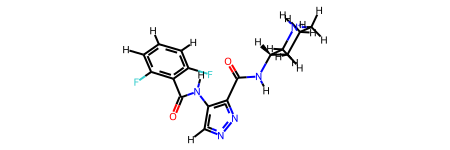

In [37]:
fragment_mols[0]

In [111]:
x=[eval(des[idx])(fragment_mols_alt) for idx,i in enumerate(des)]


In [113]:
len(x)

131

In [115]:
des=dir(rdkit.Chem.Descriptors)
des=[x for x in des if not x.startswith('AUTOCOR')]
des=[x for x in des if not x.startswith('BCUT2D')]
des=[x for x in des if not x.startswith('Chi')]
des=[x for x in des if not x.startswith('EState')]
des=[x for x in des if not x.startswith('Chem')]
des=[x for x in des if not x.startswith('PEOE')]
des=[x for x in des if not x.startswith('SlogP_')]
des=[x for x in des if not x.startswith('__')]
des=[x for x in des if not x.startswith('VSA_')]
des=[x for x in des if not x.startswith('descList')]
des=[x for x in des if not x.startswith('autocorr')]
des=[x for x in des if not x.startswith('abc')]
des=[x for x in des if not x.startswith('_')]
des=[x for x in des if not x.startswith('SMR')]
des=[x for x in des if not x.startswith('PropertyFunctor')]
des=[x for x in des if not x.startswith('names')]
des=[x for x in des if not x.startswith('setupAUTOCorrDescriptors')]
des=[x for x in des if not x.startswith('rdPartialCharges')]
des=[x for x in des if not x.startswith('rdMolDescriptors')]
des=["Descriptors."+ item for item in des]

x=[eval(des[idx])(fragment_mols_alt) for idx,i in enumerate(des)]

In [8]:
FragID.append(Descriptors.rdMolDescriptors.GetFeatureInvariants(fragment_mols_alt))

In [37]:
FragID={}

def FragID_assign(mol):
    invariantID=AllChem.GetHashedMorganFingerprint(mol,radius=2,nBits=1024)
    key=str(''.join([str(item) for item in invariantID]))
    try:
        return FragID[key]
    except:
        FragID[key] = len(FragID)+1
        return FragID[key]
    
    
# class UniqueFragID(Descriptors.PropertyFunctor):

#     def __init__(self):
#         Descriptors.PropertyFunctor.__init__(self, "UniqueFragID", "1.0.0")

#     def __call__(self, mol):
#         return mol.FragID_assign()
# UniqueFragID = UniqueFragID()

In [32]:
FragID

{}

In [117]:

invariantID=Descriptors.rdMolDescriptors.GetFeatureInvariants(fragment_mols_alt)
key=str(''.join([str(item) for item in invariantID]))

FragID.get(key)

3

In [42]:
FragID

{'00000000000000000100000000000000000000000000000000000000000000004000000000000000100000000000000000000000000000000010000000000000100000001000000000010000000000000000000100000004000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000010001000000000000000000000000000000000000000000000001000101000000000000000000000000101000900000100000100000000010000000000000100001000000000000100000000000000000030000000000000000000000200000000000000000000000000000000010100000000000000100000000000000000000000000000000010000000000000000000000000000000000010000000001000000000000000000000000000000000000000101000000000000000000000001300001000000000000000000000000000000000001000000010000000000000000000000000060000000000000000000000000000000000000000000000000000000000100000010000000000000010100000010000000000010001100000000000000012000000001000100000000000020000000000000001010010000000400000000000000000000100000010010000000000010000000000000000000000000000000000001000000011000

In [36]:
list(AllChem.GetHashedMorganFingerprint(fragment_mols_alt, radius=2,nBits=1024))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [60]:
FragID_assign(fragment_mols_alt)

NameError: name 'FragID_assign' is not defined

In [64]:
from rdkit.Chem import MACCSkeys
len(list(MACCSkeys.GenMACCSKeys(fragment_mols_alt)))

167

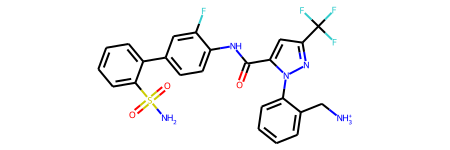

In [13]:
alt

In [6]:
alt=Chem.MolFromSmiles("NS(=O)(=O)c1ccccc1-c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2ccccc2C[NH3+])c(F)c1")

In [4]:
FragID=[0]

FragID.append(FragID.pop()+1)

In [7]:
FragID.append(FragID.pop()+1)
FragID

TypeError: 'int' object is not iterable

In [3]:
rdkit.Chem.rdMolDescriptors.Properties.RegisterProperty(UniqueFragID)

1

In [125]:
from operator import add
some=[[1,2,5,7,9,9],[2,2],[3,2],[4],[5]]
some2=[[0],[1],[0],[1],[0],[1],[0],[1],[0],[1]]

list3 = map(add, some, some2)
list(list3)

[[1, 2, 5, 7, 9, 9, 0], [2, 2, 1], [3, 2, 0], [4, 1], [5, 0]]

In [226]:
import glob
import os

uniq=[]
list_f=[x.split('/')[-1].split('.')[0].split('_')[0] for x in glob.glob('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/train/*')]

In [237]:
import pandas as pd

processed=list(set(list_f))

df=pd.read_csv('train_df_slurm.csv', names=['pdb', 'a', 'b', 'c', 'd', 'e', 'f'])


In [238]:
df

,pdb,a,b,c,d,e,f
0,5zzw,2.60,2018,5.51,3.100000e-06,5zzw.pdf,(SAH)
1,1ssq,1.85,2004,6.00,1.000000e-06,1ssq.pdf,(CYS)
2,1n3w,2.60,2003,6.96,1.100000e-07,1n3w.pdf,(MAL)
3,5y8y,1.87,2018,7.09,8.200000e-08,5y8c.pdf,(8PX)
4,5cc2,2.50,2015,4.10,8.000000e-05,5cc2.pdf,(CKA)
...,...,...,...,...,...,...,...
10857,3sus,1.80,2012,4.15,7.100000e-05,3sur.pdf,(GNL)
10858,3k39,2.54,2010,8.08,8.300000e-09,3k37.pdf,(BCZ)
10859,5hk1,2.51,2016,8.37,4.300000e-09,5hk1.pdf,(61W)
10860,1hgj,2.70,1994,1.66,2.200000e-02,1hgj.pdf,(AMN)


In [241]:
df=df[~df.pdb.str.contains('|'.join(processed))]

In [244]:
os.getcwd()

'/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn'

In [243]:
df.to_csv('train_df_slurm_unprocessed.csv', index=False, header=None)

In [234]:
unprocessed=[]

for ndx, row in df.iterrows():
    if str(row[0])  in processed:
        df[~df.Subject.str.contains('|'.join(discard))]

1ssq
1u33
6ipm
2j4k
3vd7
1k1j
2y4l
1utm
3l2y
5obr
2bq7
4hso
6rhe
6hq7
4wz6
1gz3
1rql
2jdu
4jne
6ipk
2am4
5nkk
1caq
5u51
6p84
1f0t
1tnl
1w2k
2j7h
2hf8
1ew9
4omd
4lhv
4z2b
5xs8
2vmd
3lpl
1o5g
5ost
4ipi
1f2o
3elm
4rab
2xj7
1h5v
6b2q
1gi1
5k0h
1e37
1ajq
6eq8
4fl2
4r5x
4a51
4bbh
1mmp
1bjr
5dk4
3exf
1g2l
1yid
6m9f
3ljg
5os4
4k5p
6fa3
2o9j
1gww
1puq
4caf
4emt
4p4s
6np3
5est
1atr
3hu1
2vh0
5t2t
3i3d
2jdk
1xug
3usn
3iqj
4n98
5ort
5mn1
5os0
4ido
4ywa
1nnb
1ru2
3d7m
2hqu
3zvw
6dq6
2r1x
5n3v
3f1a
5tpc
5c2a
5c29
4ufi
5tln
1q91
6ghv
4eon
3hii
1x8j
2o8h
5ags
4um9
3gy7
5l2z
1o3k
1f0u
3umq
2ynd
6v5l
3qlb
4ocp
1ax0
1jaq
3mmr
1nj1
4jyu
5ndf
3sjt
1oyt
2v7a
2w68
5nin
1ksn
3hvk
5d2a
2w08
2yne
5w44
5ett
2e91
4x8t
6ftw
3pgl
4uc5
5g57
3m35
5mnx
966c
5g1z
4a6s
6g01
3q7p
5kq5
1i6v
3fsj
3mfw
3d2e
4ele
2w87
1af6
4p5e
2w3o
4FMN
3f80
4oc5
6e4t
6eqw
5m1z
1qf1
4g5y
5jxn
6dq8
5h63
2bfr
1rm8
5ofi
6n5x
5z68
6npf
3moe
3k8d
2xzw
6egs
3hcm
5c2h
5wdc
5ywx
6ovz
3gy3
6np5
3cyz
4yes
6eab
3hwx
5eou
1m83
1oss
6bgv
3d7k
5w9g
1v2r


2pwd
6eqx
1m6p
4k6u
2vpn
1vzq
5laq
4usi
1o2t
5apr
4ngq
2rk7
2xn6
2ael
6p87
2pze
4aci
6hzc
3h9f
1we2
6dxl
6aps
3alt
6q92
5jsq
4ayr
3qxc
4ea2
1o32
6ipl
2lgf
1z2b
1qb6
2zkj
1r0x
4jn4
2vpo
6om4
5hj9
1nfx
3ocz
2j34
4h85
3ncr
1atl
6czb
6pxc
4mn3
6iht
4b7n
3cke
2haw
6ia7
5knv
5z5f
5c28
5mo2
4rcg
2boh
1xd0
3r88
4yik
4pf5
3std
5hja
1rev
6en6
6hmt
4i3z
6fi5
1ai7
5zo9
3qin
6pia
1mau
4cae
1y3n
2jkh
4gue
1y3v
3a3y
4kax
3fee
4dff
3ryw
4yt6
4gqq
4mfe
3q7q
1ql9
1v2v
6fac
4zx8
1bma
1yp9
1v11
5gmv
4lh3
3f18
1o37
1auj
4h5e
1ux7
6quv
1j14
6g02
4yih
5eto
1nj5
5jan
5x9h
3d94
1nc6
4fmo
6g2n
3rsr
5kez
6d9s
6fnq
1dhj
5j32
4uma
5yvt
1zdp
4zw3
4ayx
6p8a
1tkb
6eaa
5fv7
1lhu
6bgz
5l8c
3rbm
1ro6
4ks5
5fsb
3k39


In [1]:
import os
from os.path import exists
import builtins
import shutil
import time
import warnings
import argparse
import math
import numpy as np
import time
from datetime import datetime
import random
from sklearn import metrics
import matplotlib.pylab as plt
import pandas as pd
import pickle
import glob
from sklearn.metrics import *
from scipy.stats import *
from torch.utils.tensorboard import SummaryWriter
import subprocess
import gc
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler


# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

clip = 5
best_acc1 = 0


class Net(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(628, 157, kernel_size=1, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv3d(157, 628, kernel_size=1, stride=1),
            nn.BatchNorm3d(628),
            nn.ReLU(inplace=True))
        self.layer5 = nn.Sequential(
            nn.Conv3d(628, 1256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(1256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer6 = nn.Sequential(
            nn.Conv3d(1256, 2512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(2512),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer7 = nn.Sequential(
            nn.Conv3d(2512, 5024, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(5024),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.fc0 = nn.Linear( 40192 ,5024)
        
#         160768x2 and 40192x5024
        self.fc1 = nn.Sequential(
            nn.Linear(5024, 1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(1000, 1)

    def forward(self, x):

        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        
        out = out.reshape(out.size(0), -1)

        out = self.fc0(out)

        out = self.fc1(out)

        out = self.fc2(out)

        return out
    
model = Net()

class CNNDataLoader(Dataset):

    def __init__(self, data):
        """
        Args:
            input_pickle (string): Directory with to pickle file processed tensor data
            master_file (string): Path to the master csv file with annotations. Column 'kd\ki' has labels.
        """

        self.data = data



    def __len__(self):
           return len(self.data)

    def __getitem__(self, idx):

        grids_path, label_path = self.data[idx]

        with open(label_path,'rb') as f:
            label = pickle.load(f)

        with open(grids_path,'rb') as f:
            grid = pickle.load(f)

        #torch.unsqueeze(grid, dim=0)
        a_grid = grid[0].to_dense() if grid.shape==(1, 20, 20, 20, 628) else grid.to_dense()
        try: a_label = torch.tensor(-1 * math.log(label[0]))
        except: a_label = torch.tensor(-1 * math.log(label))
            
        return a_grid, a_label
    
    
    
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
# scheduler = torch.scheduler.reduceLROnPlateau(optimizer,patience=5)
### data ###
os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")
with open("train_data_2.pkl",'rb') as f:
    train_data=pickle.load(f)
# with open("validate_data.pkl",'rb') as f:
#     validate_data=pickle.load(f)
with open("test_data_2.pkl",'rb') as f:
    test_data=pickle.load(f)

random.Random(4).shuffle(train_data)
train_data, validate_data =train_data[:-2000], train_data[-2000:]

## test the model productivity ##
#train_data, validate_data = train_data[:2], train_data[:2]
#################################

train_dataset = CNNDataLoader(train_data)

validate_dataset = CNNDataLoader(validate_data)

test_dataset = CNNDataLoader(test_data)


#Initiate the dataloader
train_loader = DataLoader(
    train_dataset, batch_size=152, shuffle=True,
    num_workers=4)

val_loader = DataLoader(validate_dataset,
    batch_size=8, shuffle=False,
    num_workers=4)

testing_loader = DataLoader(test_dataset, batch_size=152, shuffle=True, num_workers=4)

def train(train_loader, model, criterion, optimizer, epoch):
    r2s = []

    model.train()

    end = time.time()
    for step, (inp,target) in enumerate(train_loader):
        print("step: ", step)

        target = target.view(target.shape[0], 1)
        inp = inp.view(inp.shape[0],-1,20,20,20)
        
        # compute output
#         with autocast():
        output = model(inp)
        loss = criterion(output.float(), target.float())

        # measure R2 and record loss
        ytrue = target.detach().cpu().float().data.numpy()
        ypred = output.detach().cpu().float().data.numpy()

        try:
            r2 = r2_score(ytrue, ypred)
            print("r2", r2)
            r2s.append(r2)
        except:
            print("nan values in ypred")

#         losses.update(loss.item(), inp.size(0))

        # compute gradient and do ADAM step
        optimizer.zero_grad(set_to_none=True)
        loss.backward(retain_graph=False)
        optimizer.step()
#         scaler.scale(loss).backward(retain_graph=False)
        #torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
#         scaler.step(optimizer)
#         scaler.update()
        print("loss backward", loss.data.item())
#         print("time", datetime.now())

        # torch.cuda.empty_cache()  #decrease about 2GB
        # del loss  # nothing change
        # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()
print("starting training ..")
### main loop ###
for epoch in range(0, 100):
    print("epoch: ", epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    acc1 = epoch + 1 # dummy
    # evaluate on validation set
    if epoch != 0 and epoch % 100 == 0:
        acc1 = validate(val_loader, model, criterion, args)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    
    #calculate val_loss
#     scheduler.step(val_loss)



starting training ..
epoch:  0
step:  0
r2 -11.269991835560393
loss backward 241.03387451171875
step:  1
r2 -8.482535043039682
loss backward 188.53036499023438
step:  2
r2 -7.120417700531473
loss backward 158.84521484375
step:  3
r2 -5.48680041995771
loss backward 145.44496154785156
step:  4
r2 -5.380313298522959
loss backward 105.90420532226562
step:  5
r2 -3.1530354513191625
loss backward 103.43376159667969
step:  6
r2 -4.088042672850811


KeyboardInterrupt: 

In [279]:
for b in train_loader:
    print(b)
    break

[tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 0., 0., 0.],
           ...,
          

In [ ]:
def replace_deep(data, a, b):
    if isinstance(data, str):
        return data.replace(a, b)
    elif isinstance(data, dict):
        return {k: replace_deep(v, a, b) for k, v in data.items()}
    elif isinstance(data, list):
        return [replace_deep(v, a, b) for v in data]
    else:
        # nothing to do?
        return data
replace_deep(checkpoint,"module.","")

In [7]:
import os
from os.path import exists
import builtins
import shutil
import time
import warnings
import argparse
import math
import numpy as np
import time
from datetime import datetime
import random
from sklearn import metrics
import matplotlib.pylab as plt
import pandas as pd
import pickle
import glob
from sklearn.metrics import *
from scipy.stats import *
from torch.utils.tensorboard import SummaryWriter
import subprocess
import gc
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')




all_feats={}

all_feats_labels={}



class Net(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(628, 157, kernel_size=1, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv3d(157, 628, kernel_size=1, stride=1),
            nn.BatchNorm3d(628),
            nn.ReLU(inplace=True))
        self.layer5 = nn.Sequential(
            nn.Conv3d(628, 1256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(1256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer6 = nn.Sequential(
            nn.Conv3d(1256, 2512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(2512),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer7 = nn.Sequential(
            nn.Conv3d(2512, 5024, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(5024),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.fc0 = nn.Linear( 40192 ,5024)

#         160768x2 and 40192x5024
        self.fc1 = nn.Sequential(
            nn.Linear(5024, 1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(1000, 1)

    def forward(self, x):

        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc0(out)

        z_feats = self.fc1(out)

        out = self.fc2(z_feats)

        return out, z_feats


class CNNDataLoader(Dataset):

    def __init__(self, data):
        """
        Args:
            input_pickle (string): Directory with to pickle file processed tensor data
            master_file (string): Path to the master csv file with annotations. Column 'kd\ki' has labels.
        """

        self.data = data



    def __len__(self):
           return len(self.data)

    def __getitem__(self, idx):

        grids_path, label_path = self.data[idx]

        with open(label_path,'rb') as f:
            label = pickle.load(f)

        with open(grids_path,'rb') as f:
            grid = pickle.load(f)
            
        name="_".join(label_path.split('/')[-1].split('.')[0].split('_')[0:2])
        labels=-1 * math.log(label)
        
        #torch.unsqueeze(grid, dim=0)
        a_grid = grid[0].to_dense() if grid.shape==(1, 20, 20, 20, 628) else grid.to_dense()
        try: a_label = torch.tensor(-1 * math.log(label[0]))
        except: a_label = torch.tensor(-1 * math.log(label))

        return a_grid, a_label, name, labels
    
    

    
def train(train_loader, model, criterion, optimizer, epoch):
    global all_feats
    global all_feats_labels
    
    model.train()

    for step, (inp,target, name, labels) in enumerate(train_loader):
        print("step: ", step)

        target = target.view(target.shape[0], 1)
        inp = inp.view(inp.shape[0],-1,20,20,20)

        inp = inp.cuda()
        target = target.cuda()

        output, z_feats = model(inp)
        loss = criterion(output.float(), target.float())

        # measure R2 and record loss
        ytrue = target.detach().cpu().float().data.numpy()
        ypred = output.detach().cpu().float().data.numpy()

        try:
            r2 = r2_score(ytrue, ypred)
            print("r2= ", r2)
            top.update(r2, inp.size(0))
            r2s.append(r2)
        except:
            print("nan values in ypred")

        feats = {name[i]: z_feats[i].detach().cpu().float().data.numpy() for i in range(len(name))}
        feats_labels= {name[i]: labels[i].numpy() for i in range(len(name))}
        
        all_feats.update(feats)
        all_feats_labels.update(feats_labels)
        
        print(len(all_feats), len(all_feats_labels))
        
        print("loss backward", loss.data.item())
        print("time", datetime.now())

        torch.cuda.empty_cache()  #decrease about 2GB

def validate(val_loader, model, criterion, epoch, num_classes):

    r2s=[]
    torch.cuda.empty_cache()
    # switch to evaluate mode
    model.eval()
    val_running_loss = 0.0


    with torch.no_grad():

        for step, (inp, target, name, labels) in enumerate(val_loader):

            current_loss = 0.0
            target = target.view(target.shape[0], 1)
            inp = inp.view(inp.shape[0],-1,20,20,20)

            inp = inp.cuda()
            target = target.cuda()

            output = model(inp)
            loss = criterion(output, target)

            current_loss += loss.item()
            val_running_loss += loss.item()

            # measure R2 and record loss
            ytrue = target.detach().cpu().float().data.numpy()
            ypred = output.detach().cpu().float().data.numpy()

            print(ytrue, ypred)
            r2 = r2_score(ytrue, ypred)
            r2s.append(r2)
            print("evaluation R2 score is: ", r2)


    average_r2=sum(r2s) / len(r2s)
    return average_r2
        
model = Net()
model.cuda()

criterion = nn.MSELoss().cuda()
optimizer = torch.optim.RMSprop(model.parameters(), 5e-5)

cpt='/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/model_best.pth.tar'
torch.cuda.empty_cache()
checkpoint = torch.load(cpt, map_location='cpu')

new_state_dict = {k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()}
new_state_dict_o = {k.replace('module.',''):v for k,v in checkpoint['optimizer'].items()}
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint.items():
#     name = k[7:] # remove module.
#     new_state_dict[name] = v

start_epoch = checkpoint['epoch']
best_acc1 = checkpoint['best_acc1']
#if args.gpu is not None:
#    # best_loss may be from a checkpoint from a different GPU
#    best_loss = torch.Tensor(best_loss).to(args.gpu)
model.load_state_dict(new_state_dict)
optimizer.load_state_dict(new_state_dict_o)
print("=> loaded checkpoint '{}' (epoch {})"
      .format(cpt, checkpoint['epoch']))

### data ###
os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")
with open("train_data_2.pkl",'rb') as f:
    train_data=pickle.load(f)
with open("test_data_2.pkl",'rb') as f:
    test_data=pickle.load(f)


all_labels=[]
for i in train_data:
    with open(i[1],'rb') as f2: all_labels.append(round(-1 * math.log(pickle.load(f2))))
num_classes=len(set(all_labels))
    
random.Random(4).shuffle(train_data)

train_data= train_data[-2000:]
#validate_data =val_data[-2000:]
## test the model productivity ##
#    train_data, validate_data = train_data[:1000], train_data[:1000]
#################################

train_dataset = CNNDataLoader(train_data)

validate_dataset = CNNDataLoader(validate_data)
val_sampler = None

test_dataset = CNNDataLoader(test_data)

#Initiate the dataloader
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    num_workers=6)

val_loader = DataLoader(validate_dataset,
    batch_size=16, shuffle=False,
    num_workers=6)

testing_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=6)


val_loss = []

start_epoch=0
epochs=1

print("starting training ..")
torch.cuda.empty_cache()
### main loop ###
for epoch in range(start_epoch, epochs):
    print("epoch: ", epoch)
    # train for one epoch
#     train(train_loader, model, criterion, optimizer, epoch)

#     val_epoch_loss = 100 # dummy
    # evaluate on validation set

    val_epoch_loss = validate(val_loader, model, criterion, epoch,num_classes)
    val_loss.append(val_epoch_loss)
print(val_epoch_loss)




=> loaded checkpoint '/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/model_best.pth.tar' (epoch 811)
starting training ..
epoch:  0
step:  0
r2=  0.14957922091715037
nan values in ypred
178276 178276
loss backward 10.101456642150879
time 2022-11-01 02:49:28.627678
step:  1
r2=  0.051956978998234815
nan values in ypred
178292 178292
loss backward 19.125667572021484
time 2022-11-01 02:49:29.223343
step:  2
r2=  0.15646847665928076
nan values in ypred
178308 178308
loss backward 19.680078506469727
time 2022-11-01 02:49:29.820973
step:  3
r2=  0.4415294008300161
nan values in ypred
178324 178324
loss backward 16.59981918334961
time 2022-11-01 02:49:30.432333
step:  4
r2=  0.40867597337907746
nan values in ypred
178340 178340
loss backward 21.003253936767578
time 2022-11-01 02:49:31.033945
step:  5
r2=  -1.8708289844643455
nan values in ypred
178356 178356
loss backward 20.747920989990234
time 2022-11-01 02:49:31.642118
step:  6
r2=  0.18952533704948593
nan values in ypred
1

r2=  -0.09115071648874151
nan values in ypred
179252 179252
loss backward 19.623538970947266
time 2022-11-01 02:50:05.859870
step:  62
r2=  0.37864199678420596
nan values in ypred
179268 179268
loss backward 21.418119430541992
time 2022-11-01 02:50:06.468994
step:  63
r2=  -0.26732706437574505
nan values in ypred
179284 179284
loss backward 21.502967834472656
time 2022-11-01 02:50:07.082152
step:  64
r2=  -0.11086183195617849
nan values in ypred
179300 179300
loss backward 17.954898834228516
time 2022-11-01 02:50:07.696769
step:  65
r2=  0.6822877840303094
nan values in ypred
179316 179316
loss backward 6.0699615478515625
time 2022-11-01 02:50:08.306280
step:  66
r2=  -0.7223204748730687
nan values in ypred
179332 179332
loss backward 21.137161254882812
time 2022-11-01 02:50:08.916151
step:  67
r2=  -0.0072484984172480615
nan values in ypred
179348 179348
loss backward 10.4188232421875
time 2022-11-01 02:50:09.526439
step:  68
r2=  -0.043902011645172045
nan values in ypred
179364 17936

r2=  0.5292586427138448
nan values in ypred
180244 180244
loss backward 7.233770847320557
time 2022-11-01 02:50:43.877607
step:  124
r2=  0.11226988783035896
nan values in ypred
180260 180260
loss backward 19.563705444335938
time 2022-11-01 02:50:44.489676


AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
import os
from os.path import exists
import builtins
import shutil
import time
import warnings
import argparse
import math
import numpy as np
import time
from datetime import datetime
import random
from sklearn import metrics
import matplotlib.pylab as plt
import pandas as pd
import pickle
import glob
from sklearn.metrics import *
from scipy.stats import *
from torch.utils.tensorboard import SummaryWriter
import subprocess
import gc
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
# import EarlyStopping
from pytorchtools import EarlyStopping


# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

clip = 5
best_acc1 = 0

class Net(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(628, 157, kernel_size=1, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv3d(157, 157, kernel_size=3, stride=1),
            nn.BatchNorm3d(157),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv3d(157, 628, kernel_size=1, stride=1),
            nn.BatchNorm3d(628),
            nn.ReLU(inplace=True))
        self.layer5 = nn.Sequential(
            nn.Conv3d(628, 1256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(1256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer6 = nn.Sequential(
            nn.Conv3d(1256, 2512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(2512),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.layer7 = nn.Sequential(
            nn.Conv3d(2512, 5024, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm3d(5024),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2))
        self.fc0 = nn.Sequential( 
            nn.Linear(40192 ,5024),
            nn.BatchNorm1d(5024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5))
        
#         160768x2 and 40192x5024
        self.fc1 = nn.Sequential(
            nn.Linear(5024, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(1000, 272)

    def forward(self, x):

        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        
        out = out.reshape(out.size(0), -1)

        out = self.fc0(out)

        out = self.fc1(out)

        out = self.fc2(out)
        return out
     
    
class CNNDataLoader(Dataset):

    def __init__(self, data):
        """
        Args:
            input_pickle (string): Directory with to pickle file processed tensor data
            master_file (string): Path to the master csv file with annotations. Column 'kd\ki' has labels.
        """

        self.data = data



    def __len__(self):
           return len(self.data)

    def __getitem__(self, idx):

        grids_path, label_path = self.data[idx]

        with open(label_path,'rb') as f:
            label = pickle.load(f)

        with open(grids_path,'rb') as f:
            grid = pickle.load(f)

        #torch.unsqueeze(grid, dim=0)
        a_grid = grid[0].to_dense().half() if grid.shape==(1, 20, 20, 20, 628) else grid.to_dense()
        try: a_label = torch.tensor(round(-1 * math.log(label[0]),1))
        except: a_label = torch.tensor(round(-1 * math.log(label),1))

        return a_grid, a_label
    
class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.1
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)    
    
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--net', default='3DCNN', type=str)
    parser.add_argument('--lr', default=5e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=112, type=int, help='batch size per GPU')
    parser.add_argument('--gpu', default=None, type=int)
    parser.add_argument('--start_epoch', default=0, type=int, 
                        help='start epoch number (useful on restarts)')
    parser.add_argument('--epochs', default=1500, type=int, help='number of total epochs to run')
    # DDP configs:
    parser.add_argument('--world-size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--dist-url', default='env://', type=str, 
                        help='url used to set up distributed training')
    parser.add_argument('--dist-backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
    parser.add_argument('-j', '--workers', default=6, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
    parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
    parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
    args = parser.parse_args()
    return args
                                         
def main(args):
    global best_r2

    # DDP setting
    if "WORLD_SIZE" in os.environ:
        args.world_size = int(os.environ["WORLD_SIZE"])
    args.distributed = args.world_size > 1
    ngpus_per_node = torch.cuda.device_count()

    if args.distributed:
        if args.local_rank != -1: # for torch.distributed.launch
            args.rank = args.local_rank
            args.gpu = args.local_rank
        elif 'SLURM_PROCID' in os.environ: # for slurm scheduler
            args.rank = int(os.environ['SLURM_PROCID'])
            args.gpu = args.rank % torch.cuda.device_count()
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)

    # suppress printing if not on master gpu
    if args.rank!=0:
        def print_pass(*args):
            pass
        builtins.print = print_pass
       
    ### model ###
    model = Net()
    if args.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(args.gpu)
            model.cuda(args.gpu)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
            model_without_ddp = model.module
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            model_without_ddp = model.module
    else:
        raise NotImplementedError("Only DistributedDataParallel is supported.")
        
    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)

    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    
    if args.lr_scheduler:
        print('INFO: Initializing learning rate scheduler')
        lr_scheduler = LRScheduler(optimizer)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=3, verbose=True)


    ### resume training if necessary ###
    if args.resume:
        if os.path.isfile(args.resume):
            torch.cuda.empty_cache()
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume, map_location='cpu')
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_acc1']
            if args.gpu is not None:
                # best_acc1 may be from a checkpoint from a different GPU
                best_acc1 = best_acc1.to(args.gpu)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume)) 
    
    ### data ###
    os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")
    with open("zero_train_zfeats.pkl",'rb') as f:
        train_data=pickle.load(f)
    with open("test_data_2.pkl",'rb') as f:
        test_data=pickle.load(f)

    all_labels=[]
    for i in train_data:
        with open(i[1],'rb') as f2: all_labels.append(round(-1 * math.log(pickle.load(f2))))
    num_classes=len(set(all_labels))

    random.Random(4).shuffle(train_data)
    train_data, validate_data =train_data[:-500], train_data[-500:]

## test the model productivity ##
#    train_data, validate_data = train_data[:1000], train_data[:1000]
#################################

    train_dataset = CNNDataLoader(train_data)

    validate_dataset = CNNDataLoader(validate_data)
    val_sampler = None

    test_dataset = CNNDataLoader(test_data)

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, shuffle=True)
    else:
        train_sampler = None


    #Initiate the dataloader
    train_loader = DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = DataLoader(validate_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    testing_loader = DataLoader(test_dataset, pin_memory=False, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    
    
    cudnn.benchmark = True
    
    val_loss = []

    print("starting training ..")
    torch.cuda.empty_cache()
    ### main loop ###
    for epoch in range(args.start_epoch, args.epochs):
        print("epoch: ", epoch)
        np.random.seed(epoch)
        random.seed(epoch)
        # fix sampling seed such that each gpu gets different part of dataset
        if args.distributed: 
            train_loader.sampler.set_epoch(epoch)
        
        # adjust lr if needed #
        # adjust_learning_rate(optimizer, epoch, args)
         
        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, num_classes, args)

        best_acc1=0
        # evaluate on validation set
        if epoch != 0 and epoch % 5 == 0 and args.rank == 0: # only val and save on master node
            val_epoch_loss, acc1 = validate(val_loader, model, criterion, epoch, num_classes, args)
            val_loss.append(val_epoch_loss)
                 
            if args.lr_scheduler:
                lr_scheduler(val_epoch_loss)
              
            # remember best r2 and save checkpoint
            is_best =  acc1 > best_acc1
            best_r2 = max(acc1, best_acc1)


            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.net,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer' : optimizer.state_dict(),
            }, is_best)

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_epoch_loss, model)
        
            if early_stopping.early_stop:
                print("Early stopping")
                break

           # validate(val_loader, model, criterion, epoch, args)
            # save checkpoint if needed #

def train(train_loader, model, criterion, optimizer, epoch, num_classes, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for step, (inp,target) in enumerate(train_loader):
        print("step: ", step)
        current_loss = 0.0
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.view(target.shape[0], 1)
        inp = inp.view(inp.shape[0],-1,20,20,20)

        inp = inp.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        #with autocast():
        output = model(inp)
        loss = criterion(output, torch.max(target, 1)[1])

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, min(5, num_classes)))
        losses.update(loss.item(), inp.size(0))
        top1.update(acc1[0], inp.size(0))
        top5.update(acc5[0], inp.size(0))
        
        current_loss += loss.item()
        print("optimizing memory and loss", datetime.now()) 
        # compute gradient and do ADAM step
        optimizer.zero_grad(set_to_none=True)
        loss.backward(retain_graph=False)
        optimizer.step()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
        #scaler.step(optimizer)
        #scaler.update()
        print("time", datetime.now())

        torch.cuda.empty_cache()  #decrease about 2GB
        # del loss  # nothing change
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print("epoch loss = ", loss.data.item()) 
    writer.add_scalar("Train Loss/Epochs", current_loss, epoch)
    writer.add_scalar('Accuracy (top-1)/train', top1.avg, epoch)
    writer.add_scalar('Accuracy (top-5)/train', top5.avg, epoch)

def validate(val_loader, model, criterion, epoch, num_classes, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')


    torch.cuda.empty_cache()
    # switch to evaluate mode
    model.eval()
    val_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        end = time.time()
        for step, (inp, target) in enumerate(val_loader):

            counter += 1
            current_loss = 0.0
            target = target.view(target.shape[0], 1)
            inp = inp.view(inp.shape[0],-1,20,20,20)

            inp = inp.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
           # with autocast():
            output = model(inp)
            loss = criterion(output, torch.max(target, 1)[1])

            current_loss += loss.item()
            val_running_loss += loss.item()

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, min(5, num_classes)))
            losses.update(loss.item(), inp.size(0))
            top1.update(acc1[0], inp.size(0))
            top5.update(acc5[0], inp.size(0))            

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

        val_loss = val_running_loss / counter
        writer.add_scalar("Validation Loss/Epochs", current_loss, epoch)
        writer.add_scalar('Accuracy (top-1)/val', top1.avg, epoch)
        writer.add_scalar('Accuracy (top-5)/val', top5.avg, epoch)

    print("validation epoch loss = ", loss.data.item())

    return val_loss,top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("current lr", lr)
    
        
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
 
if __name__ == '__main__':
    args = parse_args()
    writer = SummaryWriter()
    main(args)


In [173]:
lol='2izx_0_test_grids.pkl'
name="_".join(lol.split('/')[-1].split('.')[0].split('_')[0:2])

In [174]:
name

'2izx_0'

In [8]:

os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")
with open("train_all_feats_dict_zfeats.pkl",'wb') as f:
        pickle.dump(all_feats, f)
        
with open("train_all_feats_dict_labels.pkl",'wb') as f:
        pickle.dump(all_feats_labels, f)

In [4]:
import os
import pickle
os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")

In [5]:
with open("train_all_feats_dict_zfeats.pkl",'rb') as f:
    all_feats=pickle.load(f)
with open("train_all_feats_dict_labels.pkl",'rb') as f:
    all_feats_labels=pickle.load(f)

In [6]:
import pandas as pd

df1 = pd.DataFrame(all_feats_labels.items(), columns=['name', 'Target'])
df1 = df1.explode('Target')

df2 = pd.DataFrame(all_feats.items(), columns=['name', 'CNN_feats'])
#df2 = df1.explode('CNN_feats')

df=pd.merge(df1, df2, on='name')

In [19]:
os.chdir('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/general_refined_set')

fl_list=glob.glob('*')

In [27]:
desc_2d={}
for pdb in fl_list:
    print(pdb)
    try:
        desc_2d[str(pdb)] = pd.read_csv(f'{pdb}/results_plifs/{pdb}_plifs_and_properties.csv')['DESCRIPTORS_2D'][0]
    except:
        pass

2lbv
1lt6
4eoh
3zc5
6hqy
1utl
4lwi
3t4p
6oyz
5y13
4i11
5i2e
6n0q
2vvo
4tk1
1p1n
5l2w
2yay
2y7i
1i7g
1nj5
5wei
3l7d
4v04
4qmz
6f3e
3vby
4b7q
6qme
1ft7
2xln
2oz2
5ih9
5u0w
2ga2
6eox
5ypp
5z95
4a4l
4efk
4us3
4alv
5he4
5jrq
3k97
3cvk
3qck
1uyi
3oy0
2w67
5ivz
4c1y
3rr4
1mnc
4gqr
5ur1
5qc4
1apv
6cwh
6qyp
1o3f
1szm
2xxy
1hxw
4dv8
5kly
3hxb
4mvn
3u3u
4pax
5j8x
1c5y
5a14
5cas
5c7c
4a9i
5ukj
5ab0
4zuq
3juo
6hke
6g9x
2p33
5g60
4g0k
6kdi
2c4w
1ru2
4npv
4rxe
3ck8
5abw
4uco
6f6s
4lq3
6cnk
3zmv
1sqp
5ory
6jad
6t1m
2b1r
1v2j
4m5g
5zma
4rh5
3bh3
6e3n
1g4k
5c5t
5h08
5eh0
5q0n
1ntv
5lp1
3cyy
5nhf
3qfy
2afw
2hnx
3qts
2ovy
1tkx
6ic7
4bg1
6dvm
4ran
2vwl
4io2
5w5j
1tyr
2c9t
5wmt
2ksb
4lh6
5un1
6czv
2gde
6cen
5agt
2zv9
5eoc
4zx8
6oh3
5lwd
1qi0
2i0v
5zdd
4mdt
4ke1
3ig7
2ivz
6e8k
5ntq
6ixd
4zcw
4egh
5zw6
1d04
3qkv
4loi
6i78
2zhd
4dkq
5u48
5mql
3fuf
3p0g
3iux
5wdw
1rq2
4ynl
2a14
2gpp
5ue4
6qls
1xh4
1k1n
3lzb
5var
3ozt
3dcv
5zia
2qoa
6bnt
6p1d
3rsx
4xya
6iam
1kwr
4bzo
1ydr
1rjk
5ey8
6ud2
1q6j
1nnb
3npa
3qps
4awj


9hvp
6bgz
3mt7
5ose
2bqv
3e85
4muk
2e2p
4p6e
1c4v
3n8k
2q55
4ui3
4h2m
3rxd
4abv
3lq2
1x7q
5cnj
3d50
4app
4orx
4b95
5t1l
4hxq
2k7l
1n46
6e92
1w4l
6n9h
5lsx
3cj5
2j4g
4lp0
4x8n
3zls
5znr
2az5
2qtr
5kby
6qhb
5dhr
4bjx
3l79
5l98
2bvs
2bak
4mzh
4a6w
4gs6
2wkt
2nd0
4x68
5j5d
3ccn
2wyn
6seo
2zdx
5hu9
2hmu
5oh2
4lwc
4y2v
4fp1
6n7y
6e05
3qlb
6n0k
3e6k
6u8l
6ea1
3ppk
3sio
4zw5
2hd1
6qtm
5v1b
4i1r
6mep
5vil
2g00
2vt3
2bmv
3ksq
4gj9
4tyl
5ywx
2w8g
6h7z
2q15
6cb5
1ec2
5cqx
1urw
2x96
2a2g
4a4f
5jyy
2hdx
6qr7
5ar5
4lnf
5hz6
3qxm
3qce
2zga
1i5r
4tw6
6rnu
5bns
5ivt
3img
4nks
2nwn
2qbx
3wha
2q8h
6dj7
4p0v
2vk6
2i4p
3dbs
2bdy
2flh
1kvo
3ik1
3vzd
1n7i
6ind
2x09
1lb6
4ce3
3ag9
6pve
5ai8
4h3j
1uwt
3f5p
6b31
2oqv
4n1z
2hwo
6dxx
6n3y
5mgl
5w7u
3b9g
6pf5
3bjc
2nnq
3wtl
6cus
6q8c
5ody
4r73
5szb
1azg
2fxs
1n5z
4yb6
5nat
3c3o
2a5u
5uiu
1rne
5o83
1yvf
5ubg
4ql8
5zr3
4xt9
1ax1
4qz2
5vc6
4dfn
5mli
2dri
3ipu
3mxd
3pcn
1bma
6clv
3ny3
2h42
5evk
4zj8
3k5x
3hmp
1aqj
4y67
2fov
4qsk
5vqw
6e1y
3hfb
3pa8
6pys
3h30
1cnw
5ntk


2ank
2p98
5vk0
1i9l
5j59
1tsl
2pj4
3h1z
6nxz
5ief
6eq6
4ggl
4uit
2o63
5h1e
5jf5
2uuo
1o0n
5aan
2j4a
2al5
2x6i
1lhf
5i24
5xv7
2va6
4fyo
6bqk
4ge6
1g3b
5c4k
4uu8
6f34
5hg9
2h5e
5am2
3hs4
1xdd
3kl8
4n5t
2x4z
4yhf
4x6y
5ut6
6cks
4unq
2v57
2uzl
4fbx
4f8h
5afk
6ht1
4i8z
5fv7
3arf
4trz
5w99
5oae
5tq1
2igw
6bvh
1pl0
1gww
4cu8
6k5r
4qp2
2hdr
6qr1
2vfz
3che
4xx3
4zph
2vtt
4u4x
5b6c
4br3
6u6w
4djh
4rlp
5j19
6f8x
3uw4
6hk4
4jaj
5o5f
6os5
1slg
4kb9
5th4
1duv
6b5a
4tww
2i4j
6e5s
2flb
5wa8
3pe2
1yci
4o4y
3cfv
5sz7
6qi4
2avv
6r4v
4zgk
2r9x
4k1b
4bi6
4n1t
5ko1
3l3z
5mgf
4kil
2gmx
3nf6
4kwf
4yyn
4ydf
1l8g
2gfj
5h9p
6d08
5m44
6hb7
2nnk
6nwc
5zfi
5ods
2zq0
3hhm
3r8v
1zkk
5mz8
3hvg
3tk2
1bm6
4bpi
1ph0
5nvv
4o9v
5v24
6ocq
5i3x
3b7r
2lha
6r9s
2ohs
5g45
4u0x
3ibu
4kni
2drc
5e0a
5ug9
1z1r
3pch
1igb
5o8t
1lgt
4cjq
5lpl
5anv
1h3a
1jh1
5o1f
5sxm
1axr
1acj
4qzs
5vcw
3ogq
3fu5
1hkk
4i7c
4l7u
3vhd
6bik
1rlp
6iql
4j82
4z2o
4o0y
5u6b
6euc
6huu
1hi5
6r0v
1t1s
6aff
4ddy
6fv2
4hlh
2zof
4ara
4oti
2e99
3mag
3p7i
4u5u
4bs0


4xjr
6dh1
1hvk
2xae
5kjm
5ylu
3dng
2bpm
4j58
2c92
3u1i
4izm
5nxy
188l
6ajz
1gsf
4avu
2z4b
5f5i
3ckb
3fkt
5kh7
1b0h
3tfn
1i8i
5yc1
3h0w
2rvn
4c4j
1a4q
4q6r
6ghh
2yig
1wkm
6npi
3lpp
4uac
4oo9
1ogu
2jkh
3vqu
4fcd
5kap
3dej
4bio
4pkw
3rul
2pwr
5f3z
4pyq
1nyx
6eil
5ckr
4amx
5d47
5gsa
5jss
6ql1
4afj
5mlw
1w1t
3mxr
1p7m
6gfy
6knh
4kzc
3lgs
5wkh
4umn
3eml
4zh2
2uyi
1o4h
4hl5
2jbk
5aeh
1hdq
4ot6
5hmi
6mku
6dd1
1p57
3u4w
5u6v
1ghz
3s54
3nrz
6euw
4q99
4txc
3rzi
5gjd
2uw3
2qh6
4r5w
2xp7
5os4
5btx
6hza
3twv
2y4k
5igq
3bkk
6rml
1tni
2pe1
4ryg
1a0q
5wbk
1o2y
3m55
4urk
1o9e
6fhq
6p8z
6n97
6qxa
3daj
1tl3
5c6v
1u0g
6pgb
6o5u
4up5
5nih
1v16
6d1k
5nwb
5vr8
5xjm
1g37
1ke6
1mrs
6bj2
2vxn
6njz
6pz4
4li8
3wzq
3pkb
4uin
1m83
1sbg
4qme
3vbd
4rn4
4yv5
4eox
6eqw
3c2f
2a4l
4cp5
3jdw
5nne
2alv
4fi9
6hhg
6r8p
6g6z
2zif
6hva
6r1b
5tzo
5teg
3i7b
4iu1
4nmx
4z83
4ef4
3pwm
2ll6
2x4t
6as8
5ut0
1zhy
6qmu
3qc4
6jsn
1wva
5fh7
6qfg
2g72
3drr
1hxb
2pax
1yet
6bhh
6q35
6ipi
4cg8
6bvb
5nzp
3f7u
3qqu
5fap
6azk
1xbo
6aec
4dcv
1thz


2cer
4qiy
1h0a
5d1j
4qws
6b5o
1o8b
5aib
2xhm
3fr5
5dit
4bkz
6moo
3mz6
6fuh
6rj3
5oyd
1g4j
4pft
4ua8
4j52
3h78
3nal
2weh
4ahu
5qai
3f3d
3jzk
5jgb
3meu
5xij
3ds9
6dvl
5i3a
2ybu
6g7f
1gx8
6gop
2ypo
4u0a
2z94
3h0q
1a4k
5lyw
2jdv
3lpj
5xg4
6fsy
5khx
1p04
4g31
4fxf
4tzn
3kme
4gy5
2iok
5yql
5f3t
1ndj
6cq1
6eif
4loh
2zjw
5jsm
4o0b
6d5e
4mp7
2vnn
2w73
6gfs
5ehy
4utv
3pab
1uj5
4lm2
4nzo
4x5p
5jq7
6cjj
5alp
3t83
7hvp
5v7a
6qed
2vl8
1fl6
6p3w
2xyu
2xdm
1u2r
6egw
5x4n
6s8a
3q8h
1ucn
2zaz
1lq2
3k16
4lte
3jvk
6ayh
4zae
3t1l
1cze
2hxq
6dyz
1m5f
5xzr
5fng
1mmp
5btr
4kxn
2pl9
5igk
1eix
4q9z
6rmf
5nw7
5x28
3ekw
1o2s
1h8l
4zt7
2ha3
5lsc
3znr
5fl1
5vfn
2w5i
5c6p
3ws8
5h14
3py1
1ywh
5uci
5jas
5nib
4lkh
3uod
1jyi
6g1w
1t4j
3vp3
4n7y
1kz8
1ke0
1u59
4ea1
1ca8
1enu
1lan
3wzk
5h8g
6qhr
4zy4
3atk
6qad
2i1r
1swi
4jzf
5ocj
4mep
6irt
1y6a
5u7j
1n4k
5j5t
5ngs
4eor
6cd4
6ssy
1f0s
1jpl
4xe0
2vaq
5w4w
2v7a
1tcw
3ihz
5mrh
1rd4
3iof
2o48
5uf0
6gzd
4aq3
4cwb
1awi
2fuu
4dj7
6b7f
6e7x
2w8w
6iiw
3tv4
5tx3
6c85
4ym2
4a4v
4efu


4w4v
4tln
3e51
4mrg
4pry
3po1
2nq7
1g9a
1o47
2a3c
2o5k
4oaz
2d3u
5ugc
4ega
4hgs
2ff1
6dtw
2rfy
5mqe
3rz8
5c84
4el9
5wyx
4rfd
3eft
2chz
4yne
4ez3
1ero
2ai7
3svv
5alj
4fvq
4fai
4p1r
4w9s
1doj
5c1m
4nj9
1yys
1ydk
4ezz
2whp
6m87
2h2g
4zhm
3da9
3r91
4dbm
1fzq
4g8o
4l33
4rro
6rtn
5ni7
5nw1
1jd6
1ql7
6hq3
2xbx
3hio
1xt8
5i43
3doz
4g69
4xwk
3d0b
6i5g
3k8c
1rhu
5yfz
5gow
6abk
1fcz
3hu3
3r04
5g57
5mts
1jyc
4bo5
3i9g
5mme
1rt9
3iqq
3wsy
4eh9
5h1u
4rwl
3bwj
6c5h
5nn4
6ggg
2j4q
2x6y
4yje
1lhv
5uv5
6cmr
3afk
6hv0
3fv7
6r11
4mlx
4y73
6b2c
2g97
1r5h
5ts0
6gz9
4ear
5u7d
6peg
5yic
4wki
5eu1
3umo
3nsh
5v83
6hvw
6r1x
1jwt
3q4b
4zyu
3ufa
5f9e
6oip
6dgz
6hoi
4dsu
1b4d
4r6e
4in9
3fhb
4u6w
1bzh
5enj
4ac3
5t97
3arv
2usn
6qtw
3d3p
4os5
1k9r
2fgu
2mov
6g92
2qwe
5g3m
1n2v
1ylv
2tpi
5nsx
3udr
2llq
4wpf
3jpv
5f0h
5mby
1t7r
4djx
5g17
1xbc
4y5i
4is6
4z68
6a93
4jaz
5a3n
1iyl
4wn0
2ydf
4d08
5m63
6hd6
2csn
3hqz
4nwc
4qwu
3v4j
4qbm
6b5q
1d6n
2i4z
1anf
2flr
5ta6
3ztc
6fuj
1p93
1r1h
4i4e
4xxh
6mhc
1bo5
2yb0
4erz
5kxc
3nan


3rt8
1bnq
index
2wi7
1wxz
5ljt
5m39
2yof
5prc
1uy7
3oay
6mlw
2fix
2r43
3mb6
3zqi
16pk
6mzq
4fic
6msc
1dwd
4gj2
1gwv
5ybi
3el8
2l6j
1o34
1ai6
5f2k
6qr0
3chd
4hfp
6g4n
3tcp
3w9r
5j18
1tok
4gxs
5wcm
4q3t
5law
5l7g
6ugr
2cgw
4civ
3m67
3sus
4nyf
2qbq
5akg
6g28
1me4
3n2u
4i6h
5n4t
5vnb
5wa7
3dpf
4inr
1gny
3ncq
1h00
3ukr
5ai1
1sj0
6htz
4h3c
1f3j
5qcn
1ckb
2r9w
5oy3
2aog
1g49
4mf1
4zud
2hwh
4tn2
2kbr
6g9k
2rjs
4j0p
1h0w
6nyv
1nm6
4jhz
1uu7
5qa8
3f33
5wvd
4uxj
2am1
1oit
2r03
3zmi
1sqc
5orl
3kvx
3u1y
2e1w
5vee
3n7r
3iw5
5iy4
2wsx
2z4r
3ckr
5hh5
5jur
2r0z
4hbp
5op6
2ohr
4ojq
5xpl
3qtf
2zxb
3km4
4dfg
3l8v
2vie
2yiw
5ug8
4eg6
4gts
1etz
3pcg
5a6k
6f4w
5pzn
3s9i
4eu0
3lir
5wmg
5anu
5evd
5o1e
1v0n
6czi
6cea
3ouj
3dst
2mwp
1g2o
6i9a
3vhc
6bij
3s73
3wi2
4o0x
3c8e
3gjd
3f8w
7upj
3d94
1t1r
6afe
5ou3
1joc
4mw9
3kd7
4r5b
5bvw
3rl8
4u5t
5ul5
2gbi
5h5o
5wyr
5wdj
6f9t
3shv
3ux0
5hmy
3qi3
4m8h
3aje
4tjy
4g16
3fz1
3hrf
5ti0
3krx
6buu
3ozg
4txs
2i5f
4ys7
3a73
1rql
4pgb
4ezt
6pia
5nkg
3qiz
3nwb
1f4g
5b5p
1qng
6e49

2pe0
6nsv
3ni5
3a2o
6gdg
6ufo
1pme
3m54
6i0x
3lea
3v5j
1o9d
6p8y
1him
5djv
6g15
2qoh
5tb6
3w69
6n96
2xba
2yc0
5z66
4z0q
6o5t
2wtd
2xg9
4awq
4abi
4odq
5jhd
3mfw
6ft4
2xu3
4mz6
4w57
5xxf
6gbx
1e1v
3p5k
2y9g
1mkd
2rip
4nal
5cs5
1amw
4uwg
3sym
2on6
3hww
2jld
2y71
4bqy
5e88
5ij7
4fyh
4p4i
5ix1
1a37
5jfu
2liq
4o1d
5xvw
4r1v
6szj
3b1t
4k7o
2hmh
3dd0
3n49
2y0j
1j17
1mpa
1nc6
3l0e
6eh2
5bwc
2wi1
1nq0
2ax9
3hnz
4og8
2uze
6b2q
6fdp
2xzw
1r5v
4fpk
6frj
5w92
4g90
5ovf
4mcd
4ban
2p7g
3kej
1n9m
2poq
1ryf
6s9c
2cn8
6h7m
4emf
4fn5
2ajd
3g15
2vtm
1ftk
3rk5
2y5g
6nfy
4h38
3ith
4nrt
5wxo
3l5b
2j7h
3t08
2d06
5wqa
3zot
6m9d
6dq8
1y4z
5kez
3zhf
2bkz
4n84
4twp
6e5l
3ryv
5y6d
2bdl
4mha
1nhz
5wa1
3njy
3pz3
4o4r
4llj
2avo
5ok3
3qai
4mm9
1meu
3du8
1fkn
2oqi
6n3l
2ydt
3psl
4h85
3v4x
2v10
2nnd
1vcu
4dt6
4qna
4flk
3rpy
3ii5
2p3g
1rgl
3rik
6ce6
5qay
3f3t
4aaw
4lqg
2ooz
6dat
1f8a
4mr6
2ohl
4zla
6oqd
1dx6
6e83
4kup
2w92
3p2e
3ibn
3ehy
4knb
4la7
3iph
1ett
4uvu
3jq7
3wkb
1qb1
3qd0
5hvp
4m3e
3k5k
6dm8
2mip
3bf1
1il3
4l7n


5u49
6u5m
1mfa
1w6j
2yln
6nsp
4q2k
3hdz
1aht
2ha2
3fe7
3stj
2oi3
6i0r
1avn
1k1o
6m8a
1ocn
1y3w
2xii
5djp
3tu9
1my3
2yj8
1g5f
2l3r
3kid
3rqe
3lj3
5jar
4d1y
5j7b
6eee
1q6k
5m7t
3sr4
2xg3
4awk
1i2s
4oys
4odk
6e23
1g30
2ycq
5x74
5iza
1a5g
1o7o
3qs8
5avi
6qac
5aaa
5oci
5d7c
3g5v
5kit
1tx7
3e63
4bqs
3u0p
2iwu
1c2t
6h9x
1nlt
6eqp
5f4p
4mc9
2b54
4b73
5xvq
1fvv
2hmb
3mkn
2ph8
4n5g
4gzx
5l9l
2pv2
3ioe
4nmq
4b7z
1elc
5aml
4und
3qx5
1snk
6jsg
2qrp
6msy
4p2t
3ddq
2xzq
2xei
5dfp
5ia4
5ypy
2w1h
5c2o
2p7a
3ked
3rme
1h25
1ysg
2q80
6pxc
6evm
6qk8
5ak6
2wbd
5nea
4lgg
4azy
4k5z
3k22
5xmt
5of0
4i67
4zba
6dzv
1ths
5mwd
1waw
2c6o
3bla
2h13
4zg9
3wab
5k4x
2ao6
5hlp
1oky
2vd7
6fpu
4jve
4mvw
4mao
3g1v
5heb
4do3
2bkt
3kqo
5g1a
4e3g
1rwq
3rdh
6h5x
2z6w
4a9r
5ab9
1sc8
1yxd
5ap3
3m6r
3hv5
3r16
2vrx
3dg8
6g2s
1t5f
1xge
4dhl
1w5x
5mng
1u65
4dvf
4rcf
3l3m
4q1y
2gmk
2v88
6jam
5d1t
1v2s
3agm
4jmh
5okt
4zz0
2fqt
3k0h
6b3e
3duy
4kn7
3r8i
3l17
1rnt
5n0e
4l2k
5q0w
3wk7
5u8f
6eds
2wzz
2wer
5nho
1ugx
4prd
5qas
2oaz
2a5b
3ugc


1c88
1gj7
3gl6
3h0j
4q6e
2jdo
5v4q
4xhv
3zrk
4r74
4gk4
5nau
1o46
6f92
4wsk
1ax2
4b60
5ya5
3rz7
3fpd
2bz5
5c83
5e0h
1w1g
3mxe
5ehr
5ipa
1nw5
1h3h
4qer
5xs8
4hs6
3ogx
4uma
1oss
2vl1
6p3p
2xyn
4i7j
4fob
5yov
3gqz
4mwc
2who
6f05
3rlb
1cnx
6o0k
4h4e
5m2q
3sm1
4ayv
2zas
6ohu
3fnu
4i54
2r3k
5kk8
6n4t
2rku
3moh
5z1t
4n9a
4q9s
5nw0
1gt1
3ekp
4ab8
2xbw
3o4k
6miy
5aqf
1sre
1hpo
3std
6jwa
4e4x
3dhk
5iz6
5wg6
6e4c
3rxm
6h4u
2z5t
5q1c
5hi7
4exh
5jal
5t1u
4d1s
6ezg
4hxz
5oq8
5qim
4oks
5vd1
2k0g
2obf
4oym
3t6b
1mdl
6dih
3rv7
6kqi
4eh8
2vxa
2wk6
5l4i
4lp9
5eyz
6udt
1wzy
3ljt
4o13
4gng
1f73
1lag
6cfc
1oay
3skg
6mnv
4de3
5k1d
5oxk
2b7d
3pb3
4msc
6o3y
3f9y
1ynd
4eok
5jmw
5v82
5csp
1uto
3jyr
4obv
2hfp
2r6y
3mrv
4tk4
1p1q
5l2z
2rgu
5ijr
6dne
4glx
5mra
3iae
5wzt
3l7g
4zb6
6hm2
6mey
1zhl
5mb1
2oz5
3aya
4fbe
6rn7
2bfq
2j77
3rtm
6h0u
4a4o
1nxy
4o6w
4lno
5he7
3qxv
2fs8
3miy
3oy3
1xbb
4n3r
1kv1
5tqe
1yc1
4rsk
2nww
4er2
1ejn
5akw
2aa6
3h2a
3zvv
3qo2
2xct
6qre
3hxe
2fzk
5dpa
6inm
1s26
4yy6
1koj
3s45
6j72
4ery
5cav


2hl4
3obu
6fer
1d4p
2qlj
1onp
2xtk
1hti
5vja
5khk
4ijq
3s72
5qtu
220l
4oas
5jzn
6oxz
4o7c
4hgl
5ou2
3tkz
3jqa
3rl7
6g5j
3kr0
1l6y
3rz1
2yns
1inq
2z78
5wyq
4q4p
1h3b
4nzb
1axs
2qcm
5hfj
1k3t
4b6q
5xs2
5alc
6g34
3tb6
1zuc
5vad
4fab
4i7d
4mic
4w9l
1a09
5wb3
6enx
5f1x
3ll8
5d25
1f4f
2k2r
4ayp
3f6e
2ork
1fzj
5q18
4a16
1pmu
5j71
6ee4
4urz
2wf3
5ni0
4lk6
1h1s
4nxs
4x3t
4gid
4q9m
4uyf
2xwy
1hww
5y5w
6f7b
2xpk
2p4i
1c4y
5yfs
3n8n
3rjm
4why
2gz7
1nny
4ui6
3rxg
5f6u
5npc
5cnm
2evc
4o3c
4fk7
2hog
1qsc
2y2i
1w4o
5ieo
6ps5
1rt2
4kod
3iqj
4eh2
3pdc
3ewu
3zlv
2az8
2og8
2qtu
1v1j
5hbj
6op0
5vdr
2hm1
5vrl
4frj
6e2n
2ban
5c4t
4mzk
4yo6
1lf9
3m3z
5ngf
5cep
4lil
1jwm
2w17
6bh0
5l2t
1txr
6u8o
5wlt
4glr
6rpg
4lg6
3ivg
3s1h
3wcg
5enc
1t08
4zw8
5lvd
5mi9
5ovv
1xp1
5vio
5mw3
3if7
5vwi
2iuz
3bl0
4tyo
1rdn
2w8j
2gv7
4emv
4iue
2o4r
5ar8
4hfz
5hz9
4g2y
3qxp
3qch
4djq
5g10
1tou
1bcj
3l5r
5w9g
2j7x
4yml
4rse
3cf8
3puk
4usw
3d1z
4ll3
5eef
2x2r
5hex
6m9t
3b27
6hy7
2zz6
1ztq
6b5j
3odl
3bc3
1ii5
4yk6
4bdg
3vzg
4edy
1pq6


5xgh
4mw2
4g3e
2y6c
3s0e
6cck
5wdc
1o4q
4ufi
2chm
2qju
1b38
1erb
4i0r
2b4l
3djp
5one
5yvx
3dxj
5c8n
4w9f
1eb2
2woq
2lya
5bms
5np8
4j8t
5q12
5uc1
4gpl
4yzc
3lzs
6chh
6m8q
2xiy
1lqf
3avi
3k1j
6qxj
2vj6
1fj4
5hka
3pd8
3ij1
3vyd
4a1w
6bec
6imd
1kna
5j0d
5nwk
5cuu
4h2j
1uvt
6jn3
3at3
1sw1
4oru
2y9q
1n43
4e70
5izq
5wgq
3l9l
5nu5
4uiw
5wuk
6qas
3cj2
6f5m
2qfu
6ob0
5aok
1k4h
4p4s
3ohf
5oje
3rhx
1drk
3pi5
3c2o
6idg
2pcp
3wq6
1umw
1lf3
3nzi
6qm7
1q9d
2ogy
1aw1
1k22
3ay0
5vb6
3k41
6hvj
6r1k
1xdg
5icz
2g9q
5fqb
3bun
6c3l
2j2u
5a5r
1els
5nz2
5euk
4yvc
1wvj
4cwq
4m2r
2uzo
5afn
2xey
2zu3
3otq
5mi3
5ovp
5oah
5tq4
4dq2
2fgh
5vii
3omc
4btl
2gh7
5u5h
4e5f
2np8
3wv3
6ny0
4f65
2lsr
4zwy
2o4l
4z8a
2hdu
1hv5
5fos
6i62
4hyh
4r4i
1bjr
3c56
2n1g
1bxl
4pm0
1bcd
1ecv
6jjz
2ew5
6nri
5lto
4q1d
6gxb
3o3j
6hk7
5ezh
1zfq
4fgx
5lma
4hw2
4jog
2df6
5th7
3oyn
6fgc
4kp6
2w6u
5n9r
5tv1
6mod
2ra0
4rx7
6iuo
5n2d
4byi
4bda
6np3
2epn
4ptc
1gzc
5m6m
5b4w
4k8s
3uib
6aji
3ob0
4k1e
1xuo
5mgi
4kio
3tmk
4bw3
3nf9
1c84
5h9s
5lkr
6o21


In [93]:
df3 = pd.DataFrame(desc_2d.items(), columns=['name', 'Desc_2D'])


df=pd.merge(df, df3, on='name')

In [94]:
df_copy = df.copy()


In [95]:
df = df_copy

In [7]:
def unroll_dataframe_columns_of_lists_to_columns(df):
    new_df = pd.DataFrame()
    for col in df.columns:
        new_df = pd.concat([new_df, pd.DataFrame(df[col].values.tolist()).add_prefix(col + '_')], axis=1)
    new_df.index = df.index
    return new_df

In [22]:
df=unroll_dataframe_columns_of_lists_to_columns(df)

In [98]:
df = df[df['Desc_2D'].notna()]

In [103]:
from numpy import nan, inf
df['Desc_2D'] = df['Desc_2D'].apply(lambda x: eval(x))

In [11]:
df_train=unroll_dataframe_columns_of_lists_to_columns(df)

In [12]:
with open("test_all_feats_dict_zfeats.pkl",'rb') as f:
    all_feats=pickle.load(f)
with open("test_all_feats_dict_labels.pkl",'rb') as f:
    all_feats_labels=pickle.load(f)

In [13]:
df1 = pd.DataFrame(all_feats_labels.items(), columns=['name', 'Target'])
df1 = df1.explode('Target')

df2 = pd.DataFrame(all_feats.items(), columns=['name', 'CNN_feats'])
#df2 = df1.explode('CNN_feats')

df=pd.merge(df1, df2, on='name')

In [14]:
df_test=unroll_dataframe_columns_of_lists_to_columns(df)

In [143]:
df=df.replace([np.inf, -np.inf], np.nan)

In [151]:
df.dropna(how="all", inplace=True)

In [17]:
df_train

,name_0,Target_0,CNN_feats_0,CNN_feats_1,CNN_feats_2,CNN_feats_3,CNN_feats_4,CNN_feats_5,CNN_feats_6,CNN_feats_7,...,CNN_feats_990,CNN_feats_991,CNN_feats_992,CNN_feats_993,CNN_feats_994,CNN_feats_995,CNN_feats_996,CNN_feats_997,CNN_feats_998,CNN_feats_999
0,5aa9_13,18.866968,0.000000,3.089056,-0.021244,-0.027864,2.932485,0.000000,0.000000,-0.010270,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.093865,-0.027931
1,5fb7_19,18.158316,1.761219,-0.000260,0.000000,0.000000,0.792150,0.000000,1.370124,1.671613,...,1.259650,2.680831,0.218035,0.000000,0.000000,1.680728,1.672370,0.000000,0.004863,0.000000
2,4cix_16,10.289150,0.000000,0.000000,0.000000,1.400838,0.000000,1.199462,-0.023277,0.352348,...,1.443031,0.000000,-0.015207,-0.021471,1.328667,0.000000,1.066280,0.000000,-0.013530,1.599838
3,5q0f_19,22.763487,2.833345,0.000000,1.605050,0.000000,2.506406,0.000000,0.000000,0.000000,...,-0.007195,0.000000,0.000000,0.000000,0.392814,0.000000,0.000000,0.000000,0.000000,0.000000
4,4h1e_2,19.624654,0.000000,-0.027569,2.123472,0.000000,-0.025222,2.386060,0.000000,1.846095,...,2.996802,1.662579,0.000000,0.000000,0.000000,2.230328,2.277956,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180255,5ajo_14,11.417615,0.000000,-0.004111,1.638638,0.000000,0.609008,1.650399,1.284227,0.000000,...,0.000000,0.000000,0.000000,1.228630,1.664009,1.680184,0.000000,0.000000,-0.003675,1.573689
180256,1ugx_3,13.600399,0.000000,-0.023451,1.599180,0.000000,0.000000,1.875733,0.000000,0.000000,...,0.000000,-0.007717,-0.024506,0.000000,2.109036,1.725210,0.000000,0.000000,0.000000,0.000000
180257,5tg7_1,10.421002,1.048196,-0.015113,0.000000,1.757467,0.000000,0.000000,-0.032621,0.980499,...,0.000000,0.000000,-0.017999,-0.031282,0.000000,1.403475,1.351896,0.000000,-0.015647,1.884435
180258,5iql_18,10.501325,0.000000,0.000000,0.000000,0.000000,1.753240,-0.004464,0.000000,0.000000,...,-0.012719,0.000000,0.000000,0.000000,-0.006602,-0.000423,0.000000,0.000000,0.000000,-0.007777


In [ ]:
os.chdir("/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/")

with open("train_all_feats_dict_zfeats.pkl",'rb') as f:
    all_feats=pickle.load(f)
with open("train_all_feats_dict_labels.pkl",'rb') as f:
    all_feats_labels=pickle.load(f)

In [18]:
os.chdir('/groups/cherkasvgrp/share/progressive_docking/hmslati/plif_cnn/ensemble_regressor')

In [19]:
"""
This module defines a python wrapper function for stacked ensemble regression model based on sklearn machin learning library.
"""
import numpy as np
import random
import pandas as pd
import os, pickle
import csv
from itertools import combinations
from sklearn.base import clone
from sklearn import preprocessing
import joblib
from sklearn.model_selection import train_test_split

__author__ = "Zheng Li"
__email__ = "zhengl@vt.edu"
__date__ = "Nov. 26, 2019"

class stacked_ensemble_regression():
    def __init__(self, sub_estimator, aggregator_estimator, feature_name, layers, model_number_layer, feature_ratio, sample_ratio,random_state):
        self.sub_estimator = {}
        for es in sub_estimator.keys():
            self.sub_estimator[es] = clone(sub_estimator[es])
        
        self.aggregator_estimator = {}
        for es in aggregator_estimator.keys():
            self.aggregator_estimator[es] = clone(aggregator_estimator[es])

        self.feature_name = feature_name
        self.columns = feature_name
        self.layers = layers
        self.model_number_layer = model_number_layer
        self.feature_ratio = feature_ratio
        self.sample_ratio = 1- sample_ratio
        self.random_state = random_state
        self.path = os.getcwd()

    def fit(self, X, Y):
        """
        Optimize the ensemble model parameters in the "sand box" layers with the training data.
        """
        # load the data in panda data framework
        X_df = pd.DataFrame(X, columns = self.feature_name)
        # delete the previous model parameters file and create a new one
        if os.path.exists(self.path + '/' + 'model_params'):
            os.system('rm -r model_params')
        os.mkdir('model_params')
        # enumerate and train all the sub-models in each layer 
        n = 0
        while n < self.layers:
            dir = self.path + '/model_params' + '/layer_' + str(n+1)
            os.mkdir(dir)
            num = self.model_number_layer[n]
            feature_gen = []
            feature_names = []
            DATA_params = {}
            for m in range(num):
                # select a random feature size according to the pre-defined ratio ("feature_ratio")
                columns_select = random.sample(self.feature_name, int(round(len(self.feature_name)* self.feature_ratio)))
                print ('columns_select', columns_select)
                if n == 0:
                    X_tr = X_df
                    X_tr = X_tr[columns_select].values.astype(np.float)
                else:
                    X_tr = self.X_tr[columns_select].values.astype(np.float)
                # feature preprocessing to standarize the feature for an improvement of training performance  
                scaler = preprocessing.StandardScaler()
                scaler.fit(X_tr)
                X_tr = scaler.transform(X_tr)
                # save the preprocessing parameters for prediction
                DATA_params[m] = {'mean' : scaler.mean_, 'variance': scaler.var_, 'columns': columns_select}
                # select a random sample size according to the pre-defined ratio ("sample_ratio") 
                X_train, X_test, Y_train, Y_test = train_test_split(X_tr, Y,\
                                                      test_size = self.sample_ratio, random_state= self.random_state)
                # optimize all the sub_model parameters 
                for es in self.sub_estimator:
                    self.sub_estimator[es].fit(X_train, Y_train.ravel())
                    joblib.dump(self.sub_estimator[es], dir+ '/' + es + '_' + str(m)+'.pkl')
                    feature = self.sub_estimator[es].predict(X_tr)
                    feature_gen.append(feature)
                    feature_names.append(es + '_' + str(m))
            # update 'X_tr' data for training the models at next layer  
            self.feature_name = feature_names
            self.X_tr = pd.DataFrame(np.array(feature_gen).T, columns = self.feature_name)
            # save the model parameters in pickle file
            output = open(dir+ '/' + 'params.pkl','wb')
            pickle.dump(DATA_params, output)
            output.close()
            n+=1
        # create folder for aggregation model
        self.dir_aggregator = self.path + '/model_params/' + 'aggregator'
        os.mkdir(self.dir_aggregator)
        # train the aggregator model using the data from the last layer
        for es in self.aggregator_estimator:
            self.aggregator_estimator[es].fit(self.X_tr, Y.ravel())
            joblib.dump(self.aggregator_estimator[es], self.dir_aggregator + '/' + es + '.pkl')

        return self
    
    def predict(self, X):
        """
        Ensemble model prediction using the trained model architectures. 
        """
        X_df = pd.DataFrame(X, columns = self.columns)
        if os.path.exists(self.path + '/' + 'model_params'):
            n = 0
            while n < self.layers:
                dir = self.path + '/model_params' + '/layer_' + str(n+1)
                # load in all the trained model parameters from pickle file
                f = open(dir + '/' + 'params.pkl', 'rb')
                u = pickle._Unpickler(f)
                u.encoding = 'latin1'
                DATA_params = u.load()
                f.close()
                # load in the feature columns at each layer  
                feature_names = []
                feature_gen = []
                num = self.model_number_layer[n]
                for m in range(num):
                    columns_select = DATA_params[m]['columns']
                    print('columns_select', columns_select)
                    if n == 0:
                        X_ = X_df
                        X_ = X_[columns_select].values.astype(np.float)
                    else:
                        X_ = self.X_te[columns_select].values.astype(np.float)
                    # load in the standarization parameters
                    X_ = (X_ - DATA_params[m]['mean'])/np.sqrt(DATA_params[m]['variance'])
                    # model prediction on the new data
                    for es in self.sub_estimator:
                        sub_estimator = joblib.load(dir+ '/' + es+ '_' + str(m)+'.pkl')
                        feature = sub_estimator.predict(X_)
                        feature_gen.append(feature)
                        feature_names.append(es+ '_' + str(m))
                # update 'X_te' data for training the models at next layer  
                self.X_te = pd.DataFrame(np.array(feature_gen).T, columns = feature_names)
                n+=1
            # aggregator model prediction
            for es in self.aggregator_estimator:
                aggregator_model = joblib.load(self.dir_aggregator + '/' + es + '.pkl')
                prediction = aggregator_model.predict(self.X_te)
        else:
            raise ValueError('Invalid model parameter file or model_params file is missing')
     
        return prediction

In [159]:
def clean_dataset(df):
    assert isinstance (df, pd.DataFrame), "df need to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep=~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df.iloc[:, 1:]=clean_dataset(df.iloc[:, 1:])

In [21]:
df

,name,Target,CNN_feats
0,3kmx_0,11.107460356862065,"[0.99331045, -0.009434104, 1.0116568, 1.203620..."
1,4yv5_0,14.326336181730264,"[0.7421633, -0.013409169, 0.87128705, 1.276930..."
2,3v78_0,12.750799820971846,"[0.53597313, 0.78101194, 0.26097822, -0.003423..."
3,2xm1_0,11.675444394468004,"[0.7389688, 0.62214535, 0.54790217, 0.01726664..."
4,4oag_0,14.508657738524219,"[0.5552061, 0.040915284, 0.59540385, 0.4715981..."
...,...,...,...
984,1y6r_0,23.287215694074863,"[0.8981328, -0.00023937368, 0.8361702, 0.64812..."
985,1ivp_0,17.322068455284256,"[0.32576588, 1.5760311, -0.0015402337, -0.0102..."
986,3ads_0,11.54029666176636,"[0.6011124, -0.0109329205, 0.7489148, 1.063725..."
987,1is0_0,16.11809565095832,"[0.63708025, 0.82659286, 0.34867027, -0.003283..."


In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel as C, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from stacked_ensembles import stacked_ensemble_regression
import scipy
import matplotlib.pyplot as plt

# load in data into panda data frame
#df = pd.read_csv('data.csv')
columns = df_train.columns.values.tolist()

# outlier removal                                                                                                  
#df = df[df[columns[1:]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# feature selection                                                                                                
features = df_train.columns.values.tolist()[2:]
inp_train = df_train[features].values.astype(np.float)
tar_train = df_train['Target_0']
print ('features', features)

# scaling input data                                                                                               
scaler = preprocessing.StandardScaler()                                                                    
scaler.fit(inp_train[:,0:])
inp_train = scaler.transform(inp_train[:,0:])

# test data

inp_test = df_test[features].values.astype(np.float)
tar_test = df_test['Target_0']

scaler.fit(inp_test[:,0:])
inp_test = scaler.transform(inp_test[:,0:])


# ensemble model spesifications
RF = RandomForestRegressor(random_state=0)
KNN = GridSearchCV(neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform'), 
                   cv=5,param_grid={"n_neighbors": [x for x in range(1,21)]})#weights = ['uniform', 'distance']
LASSO = linear_model.LassoCV(cv=5, random_state=0)
KR = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
params = {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}#, 'min_samples_leaf': 5}, 'max_features': 30,   
GBM = ensemble.GradientBoostingRegressor(**params)

# aggregator model(Gaussian Process regression)
kernel = 1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1)
GP = GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel= kernel, n_restarts_optimizer=0, normalize_y=False, 
                              optimizer='fmin_l_bfgs_b', random_state=None)

# split datasets for training and prediction
X_train, X_test, Y_train, Y_test = inp_train, inp_test, tar_train, tar_test #train_test_split(inp, tar, test_size = 0.25, random_state= None)

print(X_train)
# ensemble model training
sub_models = {'KNN': KNN, 'RF': RF, 'GP': GP, 'GBM': GBM, 'KR': KR}
aggregator_model = {'LASSO': LASSO} 

""" parameter expliation for the "stacked_ensemble_regression" model
sub_estimator (dict): sub-models dict (e.g., {'model_name': model}) 
aggregator_estimator (dict): aggregator model dict (e.g., {'model_name': model})
feature_name (list): list of feature names 
layers (int): number of layers 
model_number_layer (list): the number of each sub-model at each layer
feature_ratio (float): ratio of randomly selected features for training each model
sample_ratio (float): ratio of randomly selected samples size for training each model
"""
model = stacked_ensemble_regression(sub_estimator =sub_models, aggregator_estimator = aggregator_model, 
                                    feature_name = features, layers = 2, model_number_layer = [20, 10], 
                                    feature_ratio = 0.75, sample_ratio = 0.75, random_state = None)
model.fit(X_train, Y_train)

# ensemble model prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Calculate Normal distribution plot
RMSE_tr = np.sqrt(np.mean((Y_train.ravel()- Y_train_pred.ravel())**2))
RMSE_te = np.sqrt(np.mean((Y_test.ravel()- Y_test_pred.ravel())**2))
print('RMSE_tr', RMSE_tr)
print('RMSE_te', RMSE_te)

# draw the parity plot for model performance evaluation
plt.plot(Y_train, Y_train_pred, 's', markerfacecolor= 'None', markersize=4.5, markeredgecolor='grey', markeredgewidth=1)
plt.plot(Y_test, Y_test_pred, 's', markerfacecolor= 'None', markersize=4.5, markeredgecolor='b', markeredgewidth=1)
plt.show()

/tmp/ipykernel_78937/1743152246.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inp_train = df_train[features].values.astype(np.float)


features ['CNN_feats_0', 'CNN_feats_1', 'CNN_feats_2', 'CNN_feats_3', 'CNN_feats_4', 'CNN_feats_5', 'CNN_feats_6', 'CNN_feats_7', 'CNN_feats_8', 'CNN_feats_9', 'CNN_feats_10', 'CNN_feats_11', 'CNN_feats_12', 'CNN_feats_13', 'CNN_feats_14', 'CNN_feats_15', 'CNN_feats_16', 'CNN_feats_17', 'CNN_feats_18', 'CNN_feats_19', 'CNN_feats_20', 'CNN_feats_21', 'CNN_feats_22', 'CNN_feats_23', 'CNN_feats_24', 'CNN_feats_25', 'CNN_feats_26', 'CNN_feats_27', 'CNN_feats_28', 'CNN_feats_29', 'CNN_feats_30', 'CNN_feats_31', 'CNN_feats_32', 'CNN_feats_33', 'CNN_feats_34', 'CNN_feats_35', 'CNN_feats_36', 'CNN_feats_37', 'CNN_feats_38', 'CNN_feats_39', 'CNN_feats_40', 'CNN_feats_41', 'CNN_feats_42', 'CNN_feats_43', 'CNN_feats_44', 'CNN_feats_45', 'CNN_feats_46', 'CNN_feats_47', 'CNN_feats_48', 'CNN_feats_49', 'CNN_feats_50', 'CNN_feats_51', 'CNN_feats_52', 'CNN_feats_53', 'CNN_feats_54', 'CNN_feats_55', 'CNN_feats_56', 'CNN_feats_57', 'CNN_feats_58', 'CNN_feats_59', 'CNN_feats_60', 'CNN_feats_61', 'CNN_fea

/tmp/ipykernel_78937/1743152246.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inp_test = df_test[features].values.astype(np.float)


[[-0.69490208  2.74839684 -0.72865079 ... -0.64542388  2.723907
  -0.61851886]
 [ 1.46738131 -0.48840896 -0.70034526 ... -0.64542388 -0.48528807
  -0.58765833]
 [-0.69490208 -0.48813642 -0.70034526 ... -0.64542388 -0.50439716
   1.17999782]
 ...
 [ 0.59198883 -0.50397109 -0.70034526 ... -0.64542388 -0.50659643
   1.49444813]
 [-0.69490208 -0.48813642 -0.70034526 ... -0.64542388 -0.49034065
  -0.59625158]
 [ 1.14605765 -0.48813642  0.56276359 ...  0.83034622  1.20496176
  -0.58765833]]
columns_select ['CNN_feats_622', 'CNN_feats_623', 'CNN_feats_717', 'CNN_feats_223', 'CNN_feats_228', 'CNN_feats_750', 'CNN_feats_500', 'CNN_feats_257', 'CNN_feats_347', 'CNN_feats_475', 'CNN_feats_482', 'CNN_feats_305', 'CNN_feats_127', 'CNN_feats_423', 'CNN_feats_650', 'CNN_feats_327', 'CNN_feats_639', 'CNN_feats_600', 'CNN_feats_368', 'CNN_feats_945', 'CNN_feats_437', 'CNN_feats_341', 'CNN_feats_158', 'CNN_feats_761', 'CNN_feats_609', 'CNN_feats_402', 'CNN_feats_269', 'CNN_feats_918', 'CNN_feats_555', '

In [132]:
# The following command removes the H2O module for Python.
!pip uninstall h2o

# Next, use pip to install this version of the H2O Python module.
!pip install https://h2o-release.s3.amazonaws.com/h2o/rel-zygmund/2/Python/h2o-3.38.0.2-py2.py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 12.6 MB/s eta 0:00:0000:0100:01
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=88f9bf4bafdfb1076bfcd775266ea5c077fd7c268802e9e6f58cd87ab39ae2de
  Stored in directory: /home/hmslati/.cache/pip/wheels/01/49/0c/4e0a697824c7bd6516afb22e1af9d51427ccd36c74b05a297e
Successfully built future
